# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

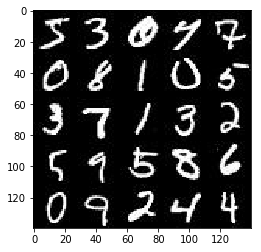

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

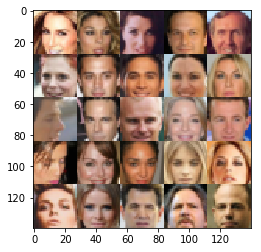

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/seth.bunke/anaconda/envs/dlnd/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    input_learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')
    
    return inputs_real, inputs_z, input_learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [19]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha=0.2
        
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [20]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """    
    with  tf.variable_scope("generator",reuse=not is_train):
        l1 = tf.layers.dense(z, 7*7*128)
        # Reshape it to start the convolutional stack
        l1 = tf.reshape(l1, (-1, 7, 7, 128))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(0.2 * l1, l1)
        # 7x7x128 now
        l2 = tf.layers.conv2d_transpose(l1, 64, 5, strides=2, padding='same')
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.maximum(0.2 * l2, l2)
        # 14x14x64 now
        # Output layer
        logits = tf.layers.conv2d_transpose(l2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        out = tf.tanh(logits)
    return out
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim) 
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True) 

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 10
    show_every = 100
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0

    input_real, input_z, input_learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps +=1
                
                # Get images, reshape and rescale to pass to D
                #batch_images = batch_images.reshape((batch_size, 784))
                batch_images = batch_images*2

                #Step 1. Random Noise to feed into G
                batch_z = np.random.uniform(-1, 1, size=(batch_size,z_dim))

                #Step 2. Run Optimizers
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = sess.run(d_loss, feed_dict={input_real: batch_images, input_z: batch_z})
                    #train_loss_d = d_loss.eval({input_z: batch_z, input_real: x})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
         
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.2293... Generator Loss: 1.8997
Epoch 0/2... Discriminator Loss: 0.1291... Generator Loss: 3.6622
Epoch 0/2... Discriminator Loss: 0.2119... Generator Loss: 2.2613
Epoch 0/2... Discriminator Loss: 0.2128... Generator Loss: 3.8886
Epoch 0/2... Discriminator Loss: 0.2147... Generator Loss: 2.2986
Epoch 0/2... Discriminator Loss: 1.4254... Generator Loss: 0.4080
Epoch 0/2... Discriminator Loss: 0.1772... Generator Loss: 2.9326
Epoch 0/2... Discriminator Loss: 0.2376... Generator Loss: 2.4367
Epoch 0/2... Discriminator Loss: 1.4390... Generator Loss: 0.4206
Epoch 0/2... Discriminator Loss: 0.4437... Generator Loss: 3.2569


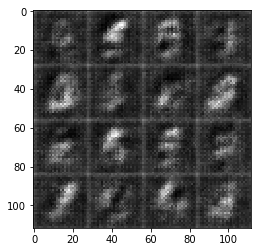

Epoch 0/2... Discriminator Loss: 0.6219... Generator Loss: 1.0790
Epoch 0/2... Discriminator Loss: 0.3597... Generator Loss: 2.1975
Epoch 0/2... Discriminator Loss: 1.8140... Generator Loss: 7.4664
Epoch 0/2... Discriminator Loss: 0.3132... Generator Loss: 2.3472
Epoch 0/2... Discriminator Loss: 0.2619... Generator Loss: 2.4775
Epoch 0/2... Discriminator Loss: 0.2424... Generator Loss: 2.3280
Epoch 0/2... Discriminator Loss: 0.3856... Generator Loss: 1.8455
Epoch 0/2... Discriminator Loss: 0.2291... Generator Loss: 2.5867
Epoch 0/2... Discriminator Loss: 0.2914... Generator Loss: 2.0041
Epoch 0/2... Discriminator Loss: 0.4253... Generator Loss: 1.4987


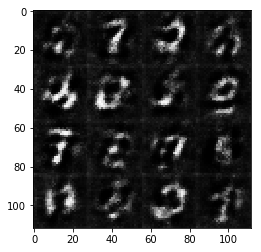

Epoch 0/2... Discriminator Loss: 0.3704... Generator Loss: 1.8088
Epoch 0/2... Discriminator Loss: 0.2189... Generator Loss: 2.3503
Epoch 0/2... Discriminator Loss: 0.2835... Generator Loss: 2.1169
Epoch 0/2... Discriminator Loss: 0.6111... Generator Loss: 1.8959
Epoch 0/2... Discriminator Loss: 0.3518... Generator Loss: 1.7215
Epoch 0/2... Discriminator Loss: 0.2869... Generator Loss: 2.1091
Epoch 0/2... Discriminator Loss: 0.2403... Generator Loss: 2.7009
Epoch 0/2... Discriminator Loss: 0.9821... Generator Loss: 5.0871
Epoch 0/2... Discriminator Loss: 0.4062... Generator Loss: 1.4354
Epoch 0/2... Discriminator Loss: 1.1642... Generator Loss: 0.4844


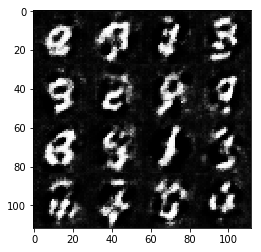

Epoch 0/2... Discriminator Loss: 0.2669... Generator Loss: 3.1650
Epoch 0/2... Discriminator Loss: 0.4343... Generator Loss: 1.3853
Epoch 0/2... Discriminator Loss: 0.3516... Generator Loss: 2.7337
Epoch 0/2... Discriminator Loss: 0.4250... Generator Loss: 1.5300
Epoch 0/2... Discriminator Loss: 0.2729... Generator Loss: 2.8523
Epoch 0/2... Discriminator Loss: 0.2938... Generator Loss: 1.9321
Epoch 0/2... Discriminator Loss: 0.2983... Generator Loss: 1.9599
Epoch 0/2... Discriminator Loss: 0.2977... Generator Loss: 1.9078
Epoch 0/2... Discriminator Loss: 0.1772... Generator Loss: 3.1478
Epoch 0/2... Discriminator Loss: 0.3945... Generator Loss: 1.5975


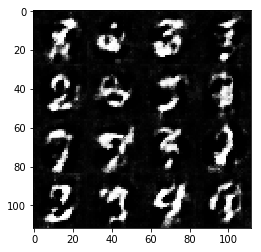

Epoch 0/2... Discriminator Loss: 0.5983... Generator Loss: 1.1774
Epoch 0/2... Discriminator Loss: 0.1467... Generator Loss: 3.0801
Epoch 0/2... Discriminator Loss: 0.2528... Generator Loss: 2.0270
Epoch 0/2... Discriminator Loss: 0.4242... Generator Loss: 1.6940
Epoch 0/2... Discriminator Loss: 0.2806... Generator Loss: 1.8971
Epoch 0/2... Discriminator Loss: 0.3215... Generator Loss: 2.0769
Epoch 0/2... Discriminator Loss: 0.1767... Generator Loss: 2.7069
Epoch 0/2... Discriminator Loss: 1.0182... Generator Loss: 5.7102
Epoch 0/2... Discriminator Loss: 0.3202... Generator Loss: 2.3875
Epoch 0/2... Discriminator Loss: 0.2941... Generator Loss: 1.6675


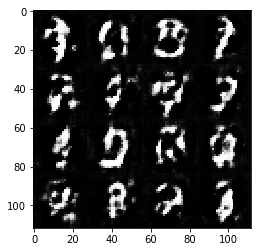

Epoch 0/2... Discriminator Loss: 0.3238... Generator Loss: 2.5477
Epoch 0/2... Discriminator Loss: 0.4605... Generator Loss: 1.3619
Epoch 0/2... Discriminator Loss: 0.1993... Generator Loss: 2.1737
Epoch 0/2... Discriminator Loss: 0.1414... Generator Loss: 3.1733
Epoch 0/2... Discriminator Loss: 0.1785... Generator Loss: 2.3070
Epoch 0/2... Discriminator Loss: 0.2276... Generator Loss: 2.2891
Epoch 0/2... Discriminator Loss: 0.1407... Generator Loss: 2.8915
Epoch 0/2... Discriminator Loss: 0.8646... Generator Loss: 5.5508
Epoch 0/2... Discriminator Loss: 0.3486... Generator Loss: 1.6897
Epoch 0/2... Discriminator Loss: 0.1491... Generator Loss: 3.0250


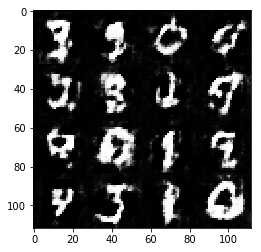

Epoch 0/2... Discriminator Loss: 0.2017... Generator Loss: 2.6177
Epoch 0/2... Discriminator Loss: 0.2189... Generator Loss: 2.1633
Epoch 0/2... Discriminator Loss: 0.3808... Generator Loss: 1.9044
Epoch 0/2... Discriminator Loss: 0.2345... Generator Loss: 2.3995
Epoch 0/2... Discriminator Loss: 0.2651... Generator Loss: 1.9135
Epoch 0/2... Discriminator Loss: 0.1243... Generator Loss: 3.2656
Epoch 0/2... Discriminator Loss: 0.1579... Generator Loss: 2.9641
Epoch 0/2... Discriminator Loss: 0.3002... Generator Loss: 1.6698
Epoch 0/2... Discriminator Loss: 0.2239... Generator Loss: 2.7384
Epoch 0/2... Discriminator Loss: 0.1580... Generator Loss: 2.7318


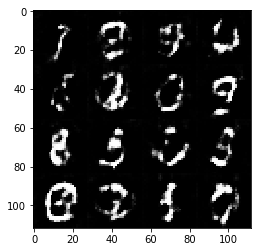

Epoch 0/2... Discriminator Loss: 0.2390... Generator Loss: 2.1541
Epoch 0/2... Discriminator Loss: 0.1617... Generator Loss: 2.5494
Epoch 0/2... Discriminator Loss: 0.1421... Generator Loss: 2.6819
Epoch 0/2... Discriminator Loss: 0.4316... Generator Loss: 4.4931
Epoch 0/2... Discriminator Loss: 0.1985... Generator Loss: 2.2958
Epoch 0/2... Discriminator Loss: 0.0981... Generator Loss: 3.5543
Epoch 0/2... Discriminator Loss: 0.1777... Generator Loss: 2.7533
Epoch 0/2... Discriminator Loss: 0.5149... Generator Loss: 1.5961
Epoch 0/2... Discriminator Loss: 0.6392... Generator Loss: 1.1587
Epoch 0/2... Discriminator Loss: 0.3899... Generator Loss: 1.5297


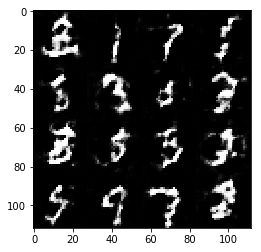

Epoch 0/2... Discriminator Loss: 0.2083... Generator Loss: 2.2899
Epoch 0/2... Discriminator Loss: 0.2364... Generator Loss: 2.0015
Epoch 0/2... Discriminator Loss: 0.3768... Generator Loss: 1.8483
Epoch 0/2... Discriminator Loss: 0.1881... Generator Loss: 2.5502
Epoch 0/2... Discriminator Loss: 0.1955... Generator Loss: 2.7777
Epoch 0/2... Discriminator Loss: 0.4066... Generator Loss: 1.8597
Epoch 0/2... Discriminator Loss: 0.4454... Generator Loss: 1.4896
Epoch 0/2... Discriminator Loss: 1.6486... Generator Loss: 0.4220
Epoch 0/2... Discriminator Loss: 0.5730... Generator Loss: 1.5217
Epoch 0/2... Discriminator Loss: 0.2082... Generator Loss: 2.4058


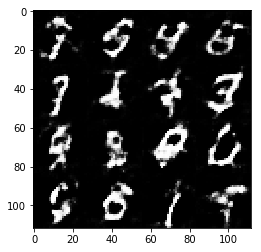

Epoch 0/2... Discriminator Loss: 0.3402... Generator Loss: 2.9061
Epoch 0/2... Discriminator Loss: 0.1869... Generator Loss: 2.8589
Epoch 0/2... Discriminator Loss: 0.7771... Generator Loss: 0.7722
Epoch 0/2... Discriminator Loss: 0.4519... Generator Loss: 1.4773
Epoch 0/2... Discriminator Loss: 0.2879... Generator Loss: 2.3607
Epoch 0/2... Discriminator Loss: 0.1812... Generator Loss: 2.3898
Epoch 0/2... Discriminator Loss: 0.3913... Generator Loss: 1.8126
Epoch 0/2... Discriminator Loss: 0.3900... Generator Loss: 5.1065
Epoch 0/2... Discriminator Loss: 0.2371... Generator Loss: 2.4386
Epoch 0/2... Discriminator Loss: 0.3632... Generator Loss: 1.8995


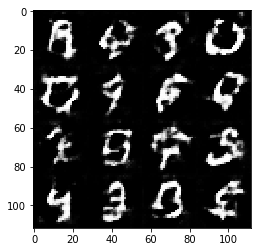

Epoch 0/2... Discriminator Loss: 0.9802... Generator Loss: 0.6945
Epoch 0/2... Discriminator Loss: 0.4154... Generator Loss: 2.7284
Epoch 0/2... Discriminator Loss: 0.2557... Generator Loss: 2.3320
Epoch 0/2... Discriminator Loss: 0.3154... Generator Loss: 1.8440
Epoch 0/2... Discriminator Loss: 0.1948... Generator Loss: 2.6843
Epoch 0/2... Discriminator Loss: 0.2399... Generator Loss: 2.3001
Epoch 0/2... Discriminator Loss: 0.1813... Generator Loss: 2.2925
Epoch 0/2... Discriminator Loss: 0.2660... Generator Loss: 1.8993
Epoch 0/2... Discriminator Loss: 0.2449... Generator Loss: 3.0854
Epoch 0/2... Discriminator Loss: 0.2203... Generator Loss: 3.0347


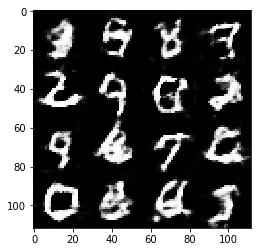

Epoch 0/2... Discriminator Loss: 1.7849... Generator Loss: 0.3909
Epoch 0/2... Discriminator Loss: 0.4641... Generator Loss: 1.5935
Epoch 0/2... Discriminator Loss: 0.1655... Generator Loss: 2.7803
Epoch 0/2... Discriminator Loss: 0.5030... Generator Loss: 1.5045
Epoch 0/2... Discriminator Loss: 0.4013... Generator Loss: 1.6679
Epoch 0/2... Discriminator Loss: 0.5614... Generator Loss: 1.3163
Epoch 0/2... Discriminator Loss: 0.6001... Generator Loss: 1.3451
Epoch 0/2... Discriminator Loss: 0.2998... Generator Loss: 2.4978
Epoch 0/2... Discriminator Loss: 0.2105... Generator Loss: 2.5430
Epoch 0/2... Discriminator Loss: 0.2252... Generator Loss: 2.5139


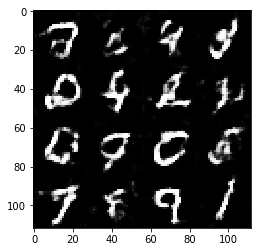

Epoch 0/2... Discriminator Loss: 0.2248... Generator Loss: 2.3978
Epoch 0/2... Discriminator Loss: 0.2664... Generator Loss: 2.0253
Epoch 0/2... Discriminator Loss: 0.2215... Generator Loss: 1.9521
Epoch 0/2... Discriminator Loss: 0.4454... Generator Loss: 1.3937
Epoch 0/2... Discriminator Loss: 0.3806... Generator Loss: 2.3874
Epoch 0/2... Discriminator Loss: 0.2592... Generator Loss: 1.9372
Epoch 0/2... Discriminator Loss: 0.9049... Generator Loss: 0.9252
Epoch 0/2... Discriminator Loss: 0.2076... Generator Loss: 2.7367
Epoch 0/2... Discriminator Loss: 0.4749... Generator Loss: 1.3254
Epoch 0/2... Discriminator Loss: 1.2592... Generator Loss: 0.3972


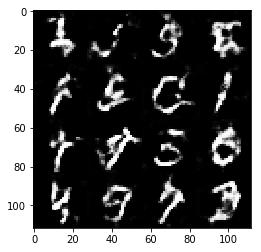

Epoch 0/2... Discriminator Loss: 0.2574... Generator Loss: 3.3741
Epoch 0/2... Discriminator Loss: 0.2376... Generator Loss: 2.2742
Epoch 0/2... Discriminator Loss: 0.6696... Generator Loss: 3.7706
Epoch 0/2... Discriminator Loss: 0.2491... Generator Loss: 2.2804
Epoch 0/2... Discriminator Loss: 0.5529... Generator Loss: 1.3575
Epoch 0/2... Discriminator Loss: 1.2084... Generator Loss: 0.6299
Epoch 0/2... Discriminator Loss: 0.4220... Generator Loss: 1.6240
Epoch 0/2... Discriminator Loss: 0.2166... Generator Loss: 2.7107
Epoch 0/2... Discriminator Loss: 0.2174... Generator Loss: 2.6420
Epoch 0/2... Discriminator Loss: 0.4112... Generator Loss: 2.0556


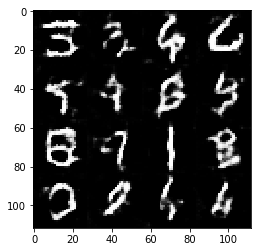

Epoch 0/2... Discriminator Loss: 0.2516... Generator Loss: 2.0942
Epoch 0/2... Discriminator Loss: 0.3763... Generator Loss: 2.4236
Epoch 0/2... Discriminator Loss: 0.9240... Generator Loss: 5.0341
Epoch 0/2... Discriminator Loss: 0.3032... Generator Loss: 2.2931
Epoch 0/2... Discriminator Loss: 0.2758... Generator Loss: 2.1255
Epoch 0/2... Discriminator Loss: 0.3226... Generator Loss: 1.7382
Epoch 0/2... Discriminator Loss: 0.5045... Generator Loss: 1.1736
Epoch 0/2... Discriminator Loss: 0.1873... Generator Loss: 2.3704
Epoch 0/2... Discriminator Loss: 0.3252... Generator Loss: 2.1195
Epoch 0/2... Discriminator Loss: 0.2510... Generator Loss: 2.0530


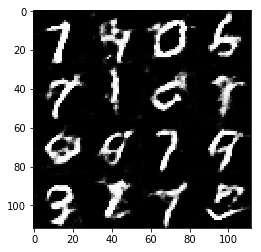

Epoch 0/2... Discriminator Loss: 0.3286... Generator Loss: 1.6905
Epoch 0/2... Discriminator Loss: 0.1927... Generator Loss: 2.4125
Epoch 0/2... Discriminator Loss: 0.6182... Generator Loss: 1.2800
Epoch 0/2... Discriminator Loss: 0.2545... Generator Loss: 1.8971
Epoch 0/2... Discriminator Loss: 1.0793... Generator Loss: 0.6133
Epoch 0/2... Discriminator Loss: 0.6101... Generator Loss: 1.1781
Epoch 0/2... Discriminator Loss: 0.3790... Generator Loss: 1.5060
Epoch 0/2... Discriminator Loss: 0.3678... Generator Loss: 2.5291
Epoch 0/2... Discriminator Loss: 0.3494... Generator Loss: 1.6978
Epoch 0/2... Discriminator Loss: 1.9553... Generator Loss: 0.1976


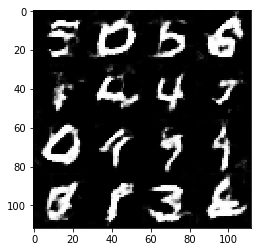

Epoch 0/2... Discriminator Loss: 0.3171... Generator Loss: 2.7275
Epoch 0/2... Discriminator Loss: 0.3815... Generator Loss: 1.6697
Epoch 0/2... Discriminator Loss: 0.3137... Generator Loss: 1.7618
Epoch 0/2... Discriminator Loss: 0.3955... Generator Loss: 1.4421
Epoch 0/2... Discriminator Loss: 0.2188... Generator Loss: 2.3217
Epoch 0/2... Discriminator Loss: 0.1919... Generator Loss: 2.3862
Epoch 0/2... Discriminator Loss: 0.4429... Generator Loss: 1.4713
Epoch 0/2... Discriminator Loss: 0.1168... Generator Loss: 2.9729
Epoch 0/2... Discriminator Loss: 0.4194... Generator Loss: 1.5483
Epoch 0/2... Discriminator Loss: 0.3062... Generator Loss: 1.9562


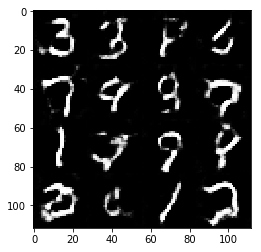

Epoch 0/2... Discriminator Loss: 0.3849... Generator Loss: 1.5627
Epoch 0/2... Discriminator Loss: 2.0684... Generator Loss: 8.3358
Epoch 0/2... Discriminator Loss: 0.8130... Generator Loss: 1.2863
Epoch 0/2... Discriminator Loss: 0.3821... Generator Loss: 1.9876
Epoch 0/2... Discriminator Loss: 0.3424... Generator Loss: 1.8716
Epoch 0/2... Discriminator Loss: 0.3303... Generator Loss: 1.7015
Epoch 0/2... Discriminator Loss: 0.4174... Generator Loss: 1.5474
Epoch 0/2... Discriminator Loss: 0.2321... Generator Loss: 2.3930
Epoch 0/2... Discriminator Loss: 0.2316... Generator Loss: 2.2287
Epoch 0/2... Discriminator Loss: 0.1981... Generator Loss: 2.4002


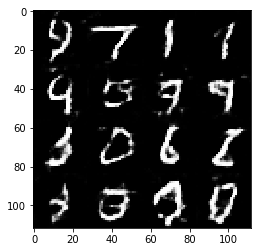

Epoch 0/2... Discriminator Loss: 0.4689... Generator Loss: 1.4099
Epoch 0/2... Discriminator Loss: 0.3226... Generator Loss: 1.7605
Epoch 0/2... Discriminator Loss: 1.0423... Generator Loss: 3.6905
Epoch 0/2... Discriminator Loss: 0.1611... Generator Loss: 2.5310
Epoch 0/2... Discriminator Loss: 0.6661... Generator Loss: 1.0127
Epoch 0/2... Discriminator Loss: 0.5307... Generator Loss: 1.3184
Epoch 0/2... Discriminator Loss: 0.2809... Generator Loss: 1.8302
Epoch 1/2... Discriminator Loss: 0.3251... Generator Loss: 1.7145
Epoch 1/2... Discriminator Loss: 0.3123... Generator Loss: 1.9361
Epoch 1/2... Discriminator Loss: 0.1426... Generator Loss: 2.5577


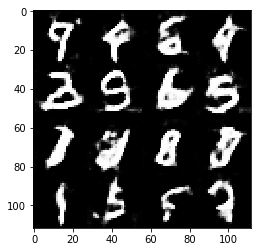

Epoch 1/2... Discriminator Loss: 0.4923... Generator Loss: 1.4319
Epoch 1/2... Discriminator Loss: 0.1558... Generator Loss: 2.6496
Epoch 1/2... Discriminator Loss: 0.4975... Generator Loss: 1.2320
Epoch 1/2... Discriminator Loss: 0.5336... Generator Loss: 1.2852
Epoch 1/2... Discriminator Loss: 0.2045... Generator Loss: 2.8821
Epoch 1/2... Discriminator Loss: 0.3551... Generator Loss: 1.5754
Epoch 1/2... Discriminator Loss: 0.4882... Generator Loss: 1.2470
Epoch 1/2... Discriminator Loss: 0.5713... Generator Loss: 1.2690
Epoch 1/2... Discriminator Loss: 0.2027... Generator Loss: 2.3283
Epoch 1/2... Discriminator Loss: 0.2915... Generator Loss: 1.7122


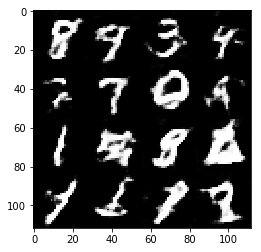

Epoch 1/2... Discriminator Loss: 0.2730... Generator Loss: 2.0129
Epoch 1/2... Discriminator Loss: 0.1343... Generator Loss: 3.0431
Epoch 1/2... Discriminator Loss: 0.4155... Generator Loss: 1.3917
Epoch 1/2... Discriminator Loss: 0.3114... Generator Loss: 1.7521
Epoch 1/2... Discriminator Loss: 0.1999... Generator Loss: 2.2137
Epoch 1/2... Discriminator Loss: 0.2712... Generator Loss: 1.9933
Epoch 1/2... Discriminator Loss: 0.4635... Generator Loss: 1.4611
Epoch 1/2... Discriminator Loss: 0.4791... Generator Loss: 1.2829
Epoch 1/2... Discriminator Loss: 0.3173... Generator Loss: 2.7301
Epoch 1/2... Discriminator Loss: 0.3014... Generator Loss: 1.8602


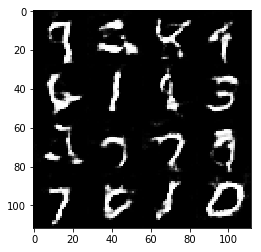

Epoch 1/2... Discriminator Loss: 0.6652... Generator Loss: 1.0364
Epoch 1/2... Discriminator Loss: 0.2966... Generator Loss: 1.8656
Epoch 1/2... Discriminator Loss: 0.1456... Generator Loss: 2.9942
Epoch 1/2... Discriminator Loss: 0.3886... Generator Loss: 1.3837
Epoch 1/2... Discriminator Loss: 0.3818... Generator Loss: 1.7627
Epoch 1/2... Discriminator Loss: 0.9291... Generator Loss: 0.7600
Epoch 1/2... Discriminator Loss: 0.2444... Generator Loss: 2.2144
Epoch 1/2... Discriminator Loss: 0.3450... Generator Loss: 1.4186
Epoch 1/2... Discriminator Loss: 0.2211... Generator Loss: 2.1399
Epoch 1/2... Discriminator Loss: 0.5004... Generator Loss: 1.2417


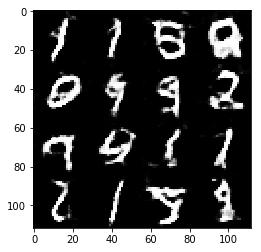

Epoch 1/2... Discriminator Loss: 0.7456... Generator Loss: 5.1763
Epoch 1/2... Discriminator Loss: 0.4547... Generator Loss: 1.7968
Epoch 1/2... Discriminator Loss: 0.9869... Generator Loss: 3.6231
Epoch 1/2... Discriminator Loss: 0.1725... Generator Loss: 2.8065
Epoch 1/2... Discriminator Loss: 0.5282... Generator Loss: 1.2644
Epoch 1/2... Discriminator Loss: 0.1903... Generator Loss: 2.4160
Epoch 1/2... Discriminator Loss: 0.3657... Generator Loss: 1.5176
Epoch 1/2... Discriminator Loss: 0.2330... Generator Loss: 2.0668
Epoch 1/2... Discriminator Loss: 0.1522... Generator Loss: 3.6310
Epoch 1/2... Discriminator Loss: 0.2273... Generator Loss: 2.2513


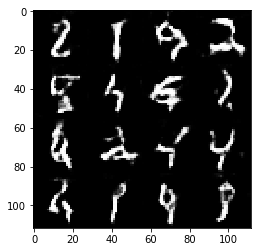

Epoch 1/2... Discriminator Loss: 0.5247... Generator Loss: 1.1936
Epoch 1/2... Discriminator Loss: 0.2995... Generator Loss: 1.8183
Epoch 1/2... Discriminator Loss: 0.3258... Generator Loss: 1.7293
Epoch 1/2... Discriminator Loss: 0.2674... Generator Loss: 5.9056
Epoch 1/2... Discriminator Loss: 0.5373... Generator Loss: 1.3859
Epoch 1/2... Discriminator Loss: 0.0646... Generator Loss: 3.9191
Epoch 1/2... Discriminator Loss: 0.2304... Generator Loss: 2.0431
Epoch 1/2... Discriminator Loss: 0.1618... Generator Loss: 2.5166
Epoch 1/2... Discriminator Loss: 0.1725... Generator Loss: 2.5181
Epoch 1/2... Discriminator Loss: 0.1765... Generator Loss: 2.1825


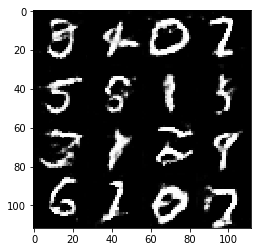

Epoch 1/2... Discriminator Loss: 0.3046... Generator Loss: 4.4549
Epoch 1/2... Discriminator Loss: 0.5101... Generator Loss: 4.0842
Epoch 1/2... Discriminator Loss: 0.4556... Generator Loss: 1.4832
Epoch 1/2... Discriminator Loss: 0.6899... Generator Loss: 0.9527
Epoch 1/2... Discriminator Loss: 0.3906... Generator Loss: 3.1594
Epoch 1/2... Discriminator Loss: 0.2797... Generator Loss: 2.0095
Epoch 1/2... Discriminator Loss: 0.4532... Generator Loss: 1.4759
Epoch 1/2... Discriminator Loss: 0.3586... Generator Loss: 1.6280
Epoch 1/2... Discriminator Loss: 0.1727... Generator Loss: 2.3893
Epoch 1/2... Discriminator Loss: 0.2469... Generator Loss: 2.0930


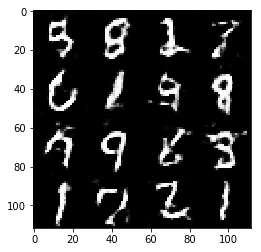

Epoch 1/2... Discriminator Loss: 0.2628... Generator Loss: 2.0070
Epoch 1/2... Discriminator Loss: 0.2041... Generator Loss: 2.0588
Epoch 1/2... Discriminator Loss: 0.1049... Generator Loss: 2.8478
Epoch 1/2... Discriminator Loss: 0.1103... Generator Loss: 2.7844
Epoch 1/2... Discriminator Loss: 0.2442... Generator Loss: 1.8236
Epoch 1/2... Discriminator Loss: 0.2576... Generator Loss: 2.4543
Epoch 1/2... Discriminator Loss: 0.1911... Generator Loss: 2.5812
Epoch 1/2... Discriminator Loss: 0.4483... Generator Loss: 1.2643
Epoch 1/2... Discriminator Loss: 0.4744... Generator Loss: 1.2766
Epoch 1/2... Discriminator Loss: 0.2858... Generator Loss: 1.5874


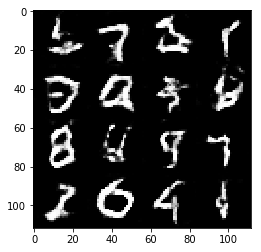

Epoch 1/2... Discriminator Loss: 0.2918... Generator Loss: 2.0215
Epoch 1/2... Discriminator Loss: 0.1871... Generator Loss: 2.1036
Epoch 1/2... Discriminator Loss: 0.6675... Generator Loss: 1.0191
Epoch 1/2... Discriminator Loss: 0.4437... Generator Loss: 1.4063
Epoch 1/2... Discriminator Loss: 0.2856... Generator Loss: 1.8479
Epoch 1/2... Discriminator Loss: 0.1913... Generator Loss: 2.2608
Epoch 1/2... Discriminator Loss: 0.1749... Generator Loss: 2.2986
Epoch 1/2... Discriminator Loss: 0.1743... Generator Loss: 2.5023
Epoch 1/2... Discriminator Loss: 0.1547... Generator Loss: 2.3516
Epoch 1/2... Discriminator Loss: 0.2577... Generator Loss: 2.9024


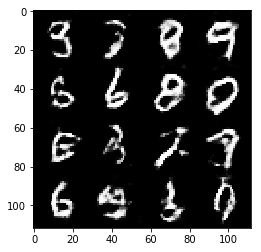

Epoch 1/2... Discriminator Loss: 0.4720... Generator Loss: 2.9860
Epoch 1/2... Discriminator Loss: 1.1357... Generator Loss: 0.5784
Epoch 1/2... Discriminator Loss: 0.4673... Generator Loss: 1.3466
Epoch 1/2... Discriminator Loss: 0.2225... Generator Loss: 2.3247
Epoch 1/2... Discriminator Loss: 0.1682... Generator Loss: 2.3219
Epoch 1/2... Discriminator Loss: 0.2972... Generator Loss: 1.7703
Epoch 1/2... Discriminator Loss: 0.2892... Generator Loss: 1.7573
Epoch 1/2... Discriminator Loss: 0.2356... Generator Loss: 2.1941
Epoch 1/2... Discriminator Loss: 0.3019... Generator Loss: 2.2042
Epoch 1/2... Discriminator Loss: 0.3498... Generator Loss: 2.8453


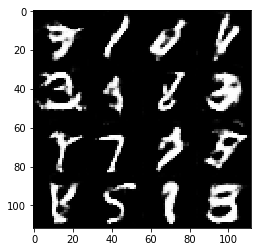

Epoch 1/2... Discriminator Loss: 0.2729... Generator Loss: 1.8696
Epoch 1/2... Discriminator Loss: 0.3225... Generator Loss: 1.8393
Epoch 1/2... Discriminator Loss: 0.4251... Generator Loss: 1.3960
Epoch 1/2... Discriminator Loss: 0.5587... Generator Loss: 1.1441
Epoch 1/2... Discriminator Loss: 0.4124... Generator Loss: 1.5335
Epoch 1/2... Discriminator Loss: 0.6188... Generator Loss: 1.0659
Epoch 1/2... Discriminator Loss: 0.3655... Generator Loss: 1.5488
Epoch 1/2... Discriminator Loss: 0.2341... Generator Loss: 1.8802
Epoch 1/2... Discriminator Loss: 0.1551... Generator Loss: 2.5877
Epoch 1/2... Discriminator Loss: 0.5846... Generator Loss: 1.1155


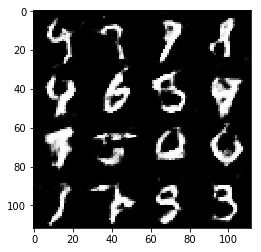

Epoch 1/2... Discriminator Loss: 0.2837... Generator Loss: 1.7927
Epoch 1/2... Discriminator Loss: 0.2954... Generator Loss: 1.7905
Epoch 1/2... Discriminator Loss: 0.2540... Generator Loss: 1.8298
Epoch 1/2... Discriminator Loss: 0.4138... Generator Loss: 1.5604
Epoch 1/2... Discriminator Loss: 0.2450... Generator Loss: 1.9222
Epoch 1/2... Discriminator Loss: 0.2161... Generator Loss: 2.0173
Epoch 1/2... Discriminator Loss: 0.4630... Generator Loss: 1.1860
Epoch 1/2... Discriminator Loss: 0.2560... Generator Loss: 1.8539
Epoch 1/2... Discriminator Loss: 0.4186... Generator Loss: 1.5711
Epoch 1/2... Discriminator Loss: 0.2193... Generator Loss: 1.9633


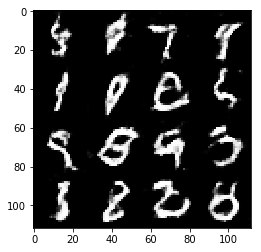

Epoch 1/2... Discriminator Loss: 1.0714... Generator Loss: 0.6232
Epoch 1/2... Discriminator Loss: 0.0790... Generator Loss: 3.1306
Epoch 1/2... Discriminator Loss: 0.1038... Generator Loss: 3.1012
Epoch 1/2... Discriminator Loss: 0.1891... Generator Loss: 2.2967
Epoch 1/2... Discriminator Loss: 0.3564... Generator Loss: 1.5639
Epoch 1/2... Discriminator Loss: 0.1875... Generator Loss: 2.2544
Epoch 1/2... Discriminator Loss: 0.2872... Generator Loss: 1.8092
Epoch 1/2... Discriminator Loss: 0.1561... Generator Loss: 2.3499
Epoch 1/2... Discriminator Loss: 0.3887... Generator Loss: 1.4612
Epoch 1/2... Discriminator Loss: 0.1062... Generator Loss: 3.2393


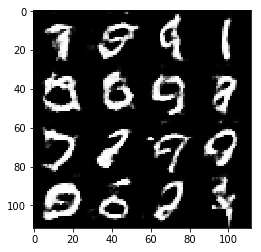

Epoch 1/2... Discriminator Loss: 0.3438... Generator Loss: 1.4808
Epoch 1/2... Discriminator Loss: 0.2121... Generator Loss: 3.0818
Epoch 1/2... Discriminator Loss: 0.2173... Generator Loss: 2.2953
Epoch 1/2... Discriminator Loss: 0.3265... Generator Loss: 1.6695
Epoch 1/2... Discriminator Loss: 0.3177... Generator Loss: 1.7337
Epoch 1/2... Discriminator Loss: 0.2185... Generator Loss: 2.0813
Epoch 1/2... Discriminator Loss: 0.3374... Generator Loss: 1.6387
Epoch 1/2... Discriminator Loss: 0.3931... Generator Loss: 1.3353
Epoch 1/2... Discriminator Loss: 0.2813... Generator Loss: 1.7671
Epoch 1/2... Discriminator Loss: 0.3747... Generator Loss: 1.6176


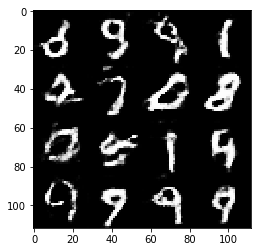

Epoch 1/2... Discriminator Loss: 0.5008... Generator Loss: 1.3179
Epoch 1/2... Discriminator Loss: 0.8841... Generator Loss: 0.6856
Epoch 1/2... Discriminator Loss: 0.5565... Generator Loss: 1.1638
Epoch 1/2... Discriminator Loss: 1.2318... Generator Loss: 4.7104
Epoch 1/2... Discriminator Loss: 0.3068... Generator Loss: 2.2435
Epoch 1/2... Discriminator Loss: 0.3550... Generator Loss: 2.2572
Epoch 1/2... Discriminator Loss: 0.2304... Generator Loss: 2.1425
Epoch 1/2... Discriminator Loss: 0.5418... Generator Loss: 1.2236
Epoch 1/2... Discriminator Loss: 0.5070... Generator Loss: 1.2698
Epoch 1/2... Discriminator Loss: 0.2117... Generator Loss: 2.3091


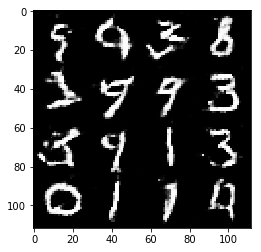

Epoch 1/2... Discriminator Loss: 0.2435... Generator Loss: 1.9561
Epoch 1/2... Discriminator Loss: 0.2925... Generator Loss: 1.6470
Epoch 1/2... Discriminator Loss: 0.4859... Generator Loss: 1.2346
Epoch 1/2... Discriminator Loss: 0.1087... Generator Loss: 2.9209
Epoch 1/2... Discriminator Loss: 0.5420... Generator Loss: 1.0973
Epoch 1/2... Discriminator Loss: 0.1854... Generator Loss: 2.2401
Epoch 1/2... Discriminator Loss: 0.1455... Generator Loss: 2.6554
Epoch 1/2... Discriminator Loss: 0.1582... Generator Loss: 2.3881
Epoch 1/2... Discriminator Loss: 0.1226... Generator Loss: 2.6347
Epoch 1/2... Discriminator Loss: 0.2929... Generator Loss: 1.7319


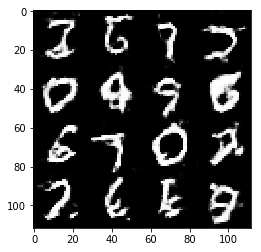

Epoch 1/2... Discriminator Loss: 0.3557... Generator Loss: 1.6625
Epoch 1/2... Discriminator Loss: 0.7119... Generator Loss: 0.9056
Epoch 1/2... Discriminator Loss: 0.4526... Generator Loss: 1.3174
Epoch 1/2... Discriminator Loss: 0.2736... Generator Loss: 1.9659
Epoch 1/2... Discriminator Loss: 0.4544... Generator Loss: 1.3466
Epoch 1/2... Discriminator Loss: 0.3828... Generator Loss: 1.5923
Epoch 1/2... Discriminator Loss: 0.2348... Generator Loss: 2.0752
Epoch 1/2... Discriminator Loss: 0.1626... Generator Loss: 2.5862
Epoch 1/2... Discriminator Loss: 2.4818... Generator Loss: 7.4897
Epoch 1/2... Discriminator Loss: 0.5186... Generator Loss: 3.7898


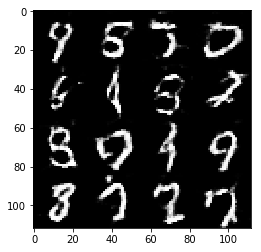

Epoch 1/2... Discriminator Loss: 0.4820... Generator Loss: 1.4044
Epoch 1/2... Discriminator Loss: 0.2527... Generator Loss: 2.3976
Epoch 1/2... Discriminator Loss: 0.4260... Generator Loss: 1.4570
Epoch 1/2... Discriminator Loss: 0.1063... Generator Loss: 3.0193
Epoch 1/2... Discriminator Loss: 0.2428... Generator Loss: 2.0900
Epoch 1/2... Discriminator Loss: 0.1423... Generator Loss: 2.5500
Epoch 1/2... Discriminator Loss: 0.3323... Generator Loss: 1.7529
Epoch 1/2... Discriminator Loss: 0.1516... Generator Loss: 2.6899
Epoch 1/2... Discriminator Loss: 0.3371... Generator Loss: 1.7285
Epoch 1/2... Discriminator Loss: 0.4710... Generator Loss: 2.0411


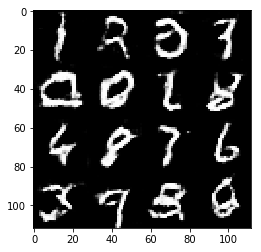

Epoch 1/2... Discriminator Loss: 0.6456... Generator Loss: 1.5590
Epoch 1/2... Discriminator Loss: 0.2567... Generator Loss: 2.2232
Epoch 1/2... Discriminator Loss: 0.1646... Generator Loss: 2.4394
Epoch 1/2... Discriminator Loss: 0.3278... Generator Loss: 1.8596
Epoch 1/2... Discriminator Loss: 0.2619... Generator Loss: 2.0750
Epoch 1/2... Discriminator Loss: 0.1316... Generator Loss: 2.8314
Epoch 1/2... Discriminator Loss: 0.2653... Generator Loss: 1.9174
Epoch 1/2... Discriminator Loss: 0.2686... Generator Loss: 1.9626
Epoch 1/2... Discriminator Loss: 0.5773... Generator Loss: 1.0792
Epoch 1/2... Discriminator Loss: 0.2962... Generator Loss: 2.9652


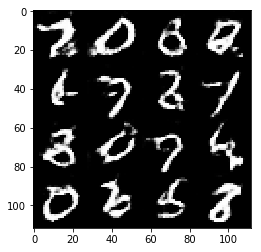

Epoch 1/2... Discriminator Loss: 0.5430... Generator Loss: 1.2152
Epoch 1/2... Discriminator Loss: 0.3398... Generator Loss: 1.6028
Epoch 1/2... Discriminator Loss: 0.0905... Generator Loss: 3.2993
Epoch 1/2... Discriminator Loss: 0.2209... Generator Loss: 2.1170
Epoch 1/2... Discriminator Loss: 0.2026... Generator Loss: 2.0651


In [25]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.1450... Generator Loss: 2.4271
Epoch 0/1... Discriminator Loss: 0.1023... Generator Loss: 2.7460
Epoch 0/1... Discriminator Loss: 0.1498... Generator Loss: 2.5022
Epoch 0/1... Discriminator Loss: 0.0703... Generator Loss: 3.1896
Epoch 0/1... Discriminator Loss: 0.0591... Generator Loss: 7.8270
Epoch 0/1... Discriminator Loss: 0.0945... Generator Loss: 3.2925
Epoch 0/1... Discriminator Loss: 0.1194... Generator Loss: 3.0999
Epoch 0/1... Discriminator Loss: 0.7394... Generator Loss: 0.9908
Epoch 0/1... Discriminator Loss: 0.5129... Generator Loss: 5.8878
Epoch 0/1... Discriminator Loss: 0.3517... Generator Loss: 1.8615


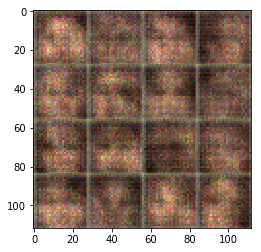

Epoch 0/1... Discriminator Loss: 1.0114... Generator Loss: 1.0391
Epoch 0/1... Discriminator Loss: 0.1787... Generator Loss: 2.6943
Epoch 0/1... Discriminator Loss: 0.2227... Generator Loss: 3.3172
Epoch 0/1... Discriminator Loss: 0.3536... Generator Loss: 1.8205
Epoch 0/1... Discriminator Loss: 0.1657... Generator Loss: 3.6914
Epoch 0/1... Discriminator Loss: 0.2806... Generator Loss: 1.9907
Epoch 0/1... Discriminator Loss: 1.2712... Generator Loss: 0.6657
Epoch 0/1... Discriminator Loss: 0.5342... Generator Loss: 1.2940
Epoch 0/1... Discriminator Loss: 0.1765... Generator Loss: 2.6410
Epoch 0/1... Discriminator Loss: 0.1502... Generator Loss: 3.3210


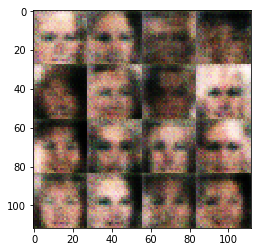

Epoch 0/1... Discriminator Loss: 0.2583... Generator Loss: 2.1129
Epoch 0/1... Discriminator Loss: 0.1943... Generator Loss: 2.7456
Epoch 0/1... Discriminator Loss: 0.3561... Generator Loss: 1.6633
Epoch 0/1... Discriminator Loss: 0.2491... Generator Loss: 3.4708
Epoch 0/1... Discriminator Loss: 0.2014... Generator Loss: 2.6304
Epoch 0/1... Discriminator Loss: 0.2471... Generator Loss: 2.4617
Epoch 0/1... Discriminator Loss: 0.3126... Generator Loss: 1.8452
Epoch 0/1... Discriminator Loss: 0.9901... Generator Loss: 0.6472
Epoch 0/1... Discriminator Loss: 0.5861... Generator Loss: 5.0338
Epoch 0/1... Discriminator Loss: 0.5192... Generator Loss: 1.2376


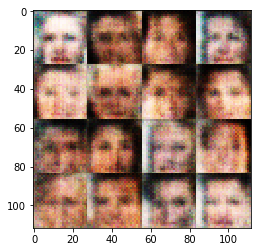

Epoch 0/1... Discriminator Loss: 0.2956... Generator Loss: 2.0650
Epoch 0/1... Discriminator Loss: 0.3120... Generator Loss: 2.1825
Epoch 0/1... Discriminator Loss: 0.2268... Generator Loss: 2.0772
Epoch 0/1... Discriminator Loss: 0.2576... Generator Loss: 3.1920
Epoch 0/1... Discriminator Loss: 0.5906... Generator Loss: 1.2723
Epoch 0/1... Discriminator Loss: 0.4051... Generator Loss: 2.3116
Epoch 0/1... Discriminator Loss: 0.3780... Generator Loss: 2.9130
Epoch 0/1... Discriminator Loss: 0.2298... Generator Loss: 1.9134
Epoch 0/1... Discriminator Loss: 0.5529... Generator Loss: 3.0421
Epoch 0/1... Discriminator Loss: 0.2838... Generator Loss: 2.2176


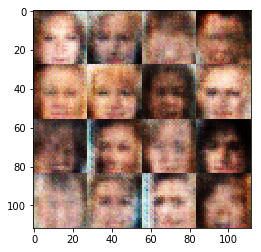

Epoch 0/1... Discriminator Loss: 0.3685... Generator Loss: 1.9184
Epoch 0/1... Discriminator Loss: 0.3964... Generator Loss: 1.6128
Epoch 0/1... Discriminator Loss: 0.4690... Generator Loss: 2.1461
Epoch 0/1... Discriminator Loss: 0.3315... Generator Loss: 1.8105
Epoch 0/1... Discriminator Loss: 0.3008... Generator Loss: 1.9036
Epoch 0/1... Discriminator Loss: 0.7562... Generator Loss: 0.8600
Epoch 0/1... Discriminator Loss: 0.1685... Generator Loss: 3.0458
Epoch 0/1... Discriminator Loss: 0.3762... Generator Loss: 2.4337
Epoch 0/1... Discriminator Loss: 0.6612... Generator Loss: 1.2283
Epoch 0/1... Discriminator Loss: 0.2814... Generator Loss: 1.7841


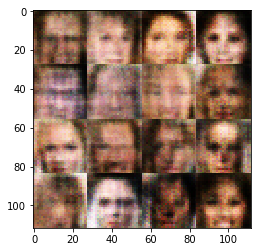

Epoch 0/1... Discriminator Loss: 0.3064... Generator Loss: 1.7034
Epoch 0/1... Discriminator Loss: 0.3966... Generator Loss: 1.9357
Epoch 0/1... Discriminator Loss: 0.8649... Generator Loss: 0.7828
Epoch 0/1... Discriminator Loss: 0.3130... Generator Loss: 2.7981
Epoch 0/1... Discriminator Loss: 0.5150... Generator Loss: 1.3394
Epoch 0/1... Discriminator Loss: 0.3710... Generator Loss: 1.6695
Epoch 0/1... Discriminator Loss: 0.4319... Generator Loss: 1.4896
Epoch 0/1... Discriminator Loss: 0.3341... Generator Loss: 3.7052
Epoch 0/1... Discriminator Loss: 2.1651... Generator Loss: 5.1084
Epoch 0/1... Discriminator Loss: 0.4621... Generator Loss: 2.3477


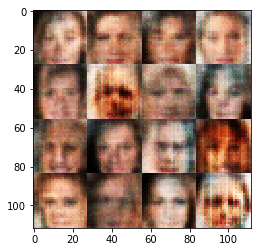

Epoch 0/1... Discriminator Loss: 0.7094... Generator Loss: 0.9815
Epoch 0/1... Discriminator Loss: 0.3377... Generator Loss: 1.8691
Epoch 0/1... Discriminator Loss: 0.5590... Generator Loss: 1.2012
Epoch 0/1... Discriminator Loss: 0.5260... Generator Loss: 2.0648
Epoch 0/1... Discriminator Loss: 0.4745... Generator Loss: 1.4816
Epoch 0/1... Discriminator Loss: 0.6753... Generator Loss: 1.3400
Epoch 0/1... Discriminator Loss: 1.0283... Generator Loss: 0.6146
Epoch 0/1... Discriminator Loss: 0.8348... Generator Loss: 2.5214
Epoch 0/1... Discriminator Loss: 1.0973... Generator Loss: 0.6014
Epoch 0/1... Discriminator Loss: 0.6897... Generator Loss: 1.7997


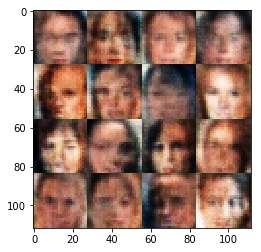

Epoch 0/1... Discriminator Loss: 0.5826... Generator Loss: 1.1066
Epoch 0/1... Discriminator Loss: 0.6263... Generator Loss: 1.2064
Epoch 0/1... Discriminator Loss: 0.6840... Generator Loss: 0.9851
Epoch 0/1... Discriminator Loss: 0.8764... Generator Loss: 2.8856
Epoch 0/1... Discriminator Loss: 0.4024... Generator Loss: 2.3419
Epoch 0/1... Discriminator Loss: 0.7697... Generator Loss: 1.1226
Epoch 0/1... Discriminator Loss: 0.4752... Generator Loss: 1.6375
Epoch 0/1... Discriminator Loss: 0.5301... Generator Loss: 1.4711
Epoch 0/1... Discriminator Loss: 0.6488... Generator Loss: 1.0809
Epoch 0/1... Discriminator Loss: 0.6418... Generator Loss: 1.1994


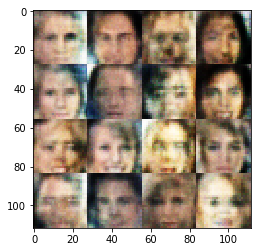

Epoch 0/1... Discriminator Loss: 0.5019... Generator Loss: 1.7726
Epoch 0/1... Discriminator Loss: 1.4514... Generator Loss: 0.4126
Epoch 0/1... Discriminator Loss: 0.5198... Generator Loss: 1.7213
Epoch 0/1... Discriminator Loss: 0.3757... Generator Loss: 2.6572
Epoch 0/1... Discriminator Loss: 0.5608... Generator Loss: 1.6496
Epoch 0/1... Discriminator Loss: 0.4197... Generator Loss: 1.6733
Epoch 0/1... Discriminator Loss: 0.5322... Generator Loss: 1.6311
Epoch 0/1... Discriminator Loss: 0.6178... Generator Loss: 1.2866
Epoch 0/1... Discriminator Loss: 0.6529... Generator Loss: 1.6026
Epoch 0/1... Discriminator Loss: 0.5579... Generator Loss: 1.4694


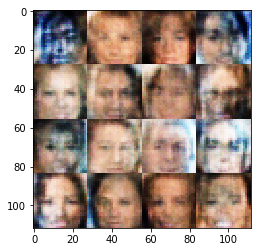

Epoch 0/1... Discriminator Loss: 0.5243... Generator Loss: 1.4936
Epoch 0/1... Discriminator Loss: 0.5451... Generator Loss: 1.1802
Epoch 0/1... Discriminator Loss: 1.1026... Generator Loss: 2.4144
Epoch 0/1... Discriminator Loss: 0.5425... Generator Loss: 1.1793
Epoch 0/1... Discriminator Loss: 0.4668... Generator Loss: 1.5980
Epoch 0/1... Discriminator Loss: 0.5999... Generator Loss: 1.5723
Epoch 0/1... Discriminator Loss: 1.0083... Generator Loss: 0.5910
Epoch 0/1... Discriminator Loss: 0.5491... Generator Loss: 1.3393
Epoch 0/1... Discriminator Loss: 0.4215... Generator Loss: 1.5978
Epoch 0/1... Discriminator Loss: 1.1830... Generator Loss: 0.4667


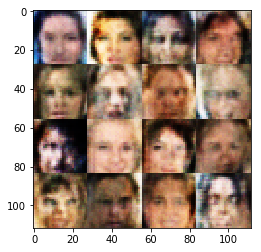

Epoch 0/1... Discriminator Loss: 0.7102... Generator Loss: 1.1026
Epoch 0/1... Discriminator Loss: 0.7918... Generator Loss: 2.4551
Epoch 0/1... Discriminator Loss: 0.8508... Generator Loss: 0.7061
Epoch 0/1... Discriminator Loss: 0.4735... Generator Loss: 2.4152
Epoch 0/1... Discriminator Loss: 0.6459... Generator Loss: 1.1680
Epoch 0/1... Discriminator Loss: 0.5401... Generator Loss: 1.3077
Epoch 0/1... Discriminator Loss: 0.5289... Generator Loss: 2.3920
Epoch 0/1... Discriminator Loss: 0.6041... Generator Loss: 1.8567
Epoch 0/1... Discriminator Loss: 0.5870... Generator Loss: 1.7292
Epoch 0/1... Discriminator Loss: 0.5675... Generator Loss: 1.5231


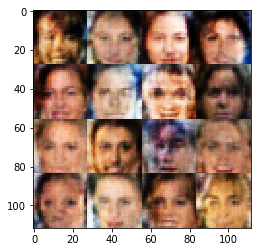

Epoch 0/1... Discriminator Loss: 0.6041... Generator Loss: 1.4041
Epoch 0/1... Discriminator Loss: 0.5006... Generator Loss: 2.3289
Epoch 0/1... Discriminator Loss: 0.7373... Generator Loss: 0.9738
Epoch 0/1... Discriminator Loss: 0.6157... Generator Loss: 1.5975
Epoch 0/1... Discriminator Loss: 0.6869... Generator Loss: 1.0349
Epoch 0/1... Discriminator Loss: 0.7047... Generator Loss: 3.0354
Epoch 0/1... Discriminator Loss: 0.6047... Generator Loss: 1.3098
Epoch 0/1... Discriminator Loss: 0.4473... Generator Loss: 1.9004
Epoch 0/1... Discriminator Loss: 0.6356... Generator Loss: 0.9604
Epoch 0/1... Discriminator Loss: 0.4849... Generator Loss: 1.5660


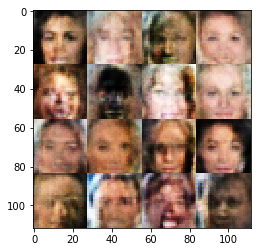

Epoch 0/1... Discriminator Loss: 0.4668... Generator Loss: 1.9790
Epoch 0/1... Discriminator Loss: 0.6020... Generator Loss: 1.3850
Epoch 0/1... Discriminator Loss: 0.6708... Generator Loss: 1.0100
Epoch 0/1... Discriminator Loss: 0.8376... Generator Loss: 0.6909
Epoch 0/1... Discriminator Loss: 0.5296... Generator Loss: 1.4938
Epoch 0/1... Discriminator Loss: 0.9496... Generator Loss: 3.4063
Epoch 0/1... Discriminator Loss: 0.5239... Generator Loss: 1.3611
Epoch 0/1... Discriminator Loss: 0.8205... Generator Loss: 0.7566
Epoch 0/1... Discriminator Loss: 0.5009... Generator Loss: 1.5383
Epoch 0/1... Discriminator Loss: 0.4261... Generator Loss: 1.5005


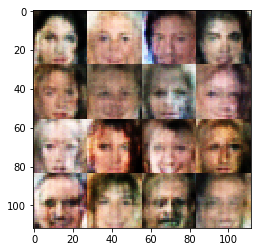

Epoch 0/1... Discriminator Loss: 0.8616... Generator Loss: 0.6462
Epoch 0/1... Discriminator Loss: 0.7058... Generator Loss: 0.7973
Epoch 0/1... Discriminator Loss: 0.3786... Generator Loss: 1.5583
Epoch 0/1... Discriminator Loss: 0.9979... Generator Loss: 0.7253
Epoch 0/1... Discriminator Loss: 0.8009... Generator Loss: 0.8524
Epoch 0/1... Discriminator Loss: 0.5189... Generator Loss: 2.1808
Epoch 0/1... Discriminator Loss: 0.7611... Generator Loss: 0.8143
Epoch 0/1... Discriminator Loss: 0.8484... Generator Loss: 0.7076
Epoch 0/1... Discriminator Loss: 0.5440... Generator Loss: 1.7784
Epoch 0/1... Discriminator Loss: 0.6609... Generator Loss: 0.9135


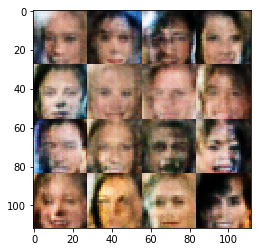

Epoch 0/1... Discriminator Loss: 0.5635... Generator Loss: 1.2673
Epoch 0/1... Discriminator Loss: 0.6207... Generator Loss: 1.0697
Epoch 0/1... Discriminator Loss: 0.6113... Generator Loss: 1.1030
Epoch 0/1... Discriminator Loss: 0.5307... Generator Loss: 2.3368
Epoch 0/1... Discriminator Loss: 0.7667... Generator Loss: 0.7649
Epoch 0/1... Discriminator Loss: 0.5228... Generator Loss: 1.2403
Epoch 0/1... Discriminator Loss: 0.8652... Generator Loss: 0.7414
Epoch 0/1... Discriminator Loss: 0.6447... Generator Loss: 0.9297
Epoch 0/1... Discriminator Loss: 0.6023... Generator Loss: 1.2386
Epoch 0/1... Discriminator Loss: 0.4405... Generator Loss: 1.4846


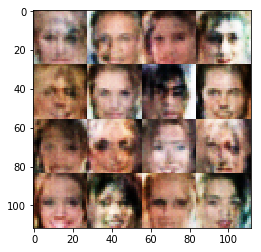

Epoch 0/1... Discriminator Loss: 0.6491... Generator Loss: 1.5314
Epoch 0/1... Discriminator Loss: 0.6072... Generator Loss: 1.7161
Epoch 0/1... Discriminator Loss: 0.6087... Generator Loss: 1.0083
Epoch 0/1... Discriminator Loss: 1.0977... Generator Loss: 3.9206
Epoch 0/1... Discriminator Loss: 0.5270... Generator Loss: 1.3494
Epoch 0/1... Discriminator Loss: 0.3906... Generator Loss: 2.3323
Epoch 0/1... Discriminator Loss: 0.4067... Generator Loss: 2.2935
Epoch 0/1... Discriminator Loss: 0.3363... Generator Loss: 1.9342
Epoch 0/1... Discriminator Loss: 0.6124... Generator Loss: 1.5429
Epoch 0/1... Discriminator Loss: 0.9395... Generator Loss: 0.6122


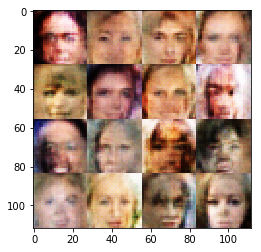

Epoch 0/1... Discriminator Loss: 1.0781... Generator Loss: 0.5805
Epoch 0/1... Discriminator Loss: 0.6671... Generator Loss: 1.5664
Epoch 0/1... Discriminator Loss: 0.7078... Generator Loss: 0.8150
Epoch 0/1... Discriminator Loss: 0.6540... Generator Loss: 1.1118
Epoch 0/1... Discriminator Loss: 0.4884... Generator Loss: 1.2633
Epoch 0/1... Discriminator Loss: 0.7857... Generator Loss: 1.2294
Epoch 0/1... Discriminator Loss: 0.4130... Generator Loss: 1.6428
Epoch 0/1... Discriminator Loss: 0.8578... Generator Loss: 0.7978
Epoch 0/1... Discriminator Loss: 0.5734... Generator Loss: 2.2197
Epoch 0/1... Discriminator Loss: 0.7422... Generator Loss: 0.8167


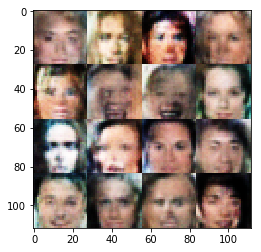

Epoch 0/1... Discriminator Loss: 0.3778... Generator Loss: 1.4046
Epoch 0/1... Discriminator Loss: 0.4077... Generator Loss: 1.7381
Epoch 0/1... Discriminator Loss: 0.4237... Generator Loss: 1.4305
Epoch 0/1... Discriminator Loss: 0.5035... Generator Loss: 1.6108
Epoch 0/1... Discriminator Loss: 0.6396... Generator Loss: 2.3572
Epoch 0/1... Discriminator Loss: 0.3269... Generator Loss: 1.9963
Epoch 0/1... Discriminator Loss: 0.9573... Generator Loss: 0.9424
Epoch 0/1... Discriminator Loss: 1.0013... Generator Loss: 0.6496
Epoch 0/1... Discriminator Loss: 0.7580... Generator Loss: 0.9674
Epoch 0/1... Discriminator Loss: 0.4827... Generator Loss: 1.2902


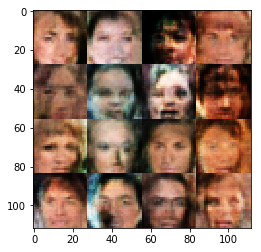

Epoch 0/1... Discriminator Loss: 0.4028... Generator Loss: 1.5875
Epoch 0/1... Discriminator Loss: 0.5854... Generator Loss: 1.3325
Epoch 0/1... Discriminator Loss: 0.6161... Generator Loss: 1.0726
Epoch 0/1... Discriminator Loss: 0.4459... Generator Loss: 1.2935
Epoch 0/1... Discriminator Loss: 0.4533... Generator Loss: 1.3038
Epoch 0/1... Discriminator Loss: 0.3116... Generator Loss: 2.2289
Epoch 0/1... Discriminator Loss: 0.4474... Generator Loss: 1.4725
Epoch 0/1... Discriminator Loss: 0.3753... Generator Loss: 2.6162
Epoch 0/1... Discriminator Loss: 0.9157... Generator Loss: 0.7736
Epoch 0/1... Discriminator Loss: 0.4823... Generator Loss: 1.4956


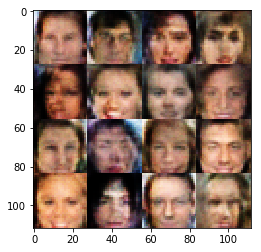

Epoch 0/1... Discriminator Loss: 0.6514... Generator Loss: 1.4999
Epoch 0/1... Discriminator Loss: 1.5036... Generator Loss: 0.3441
Epoch 0/1... Discriminator Loss: 0.5747... Generator Loss: 2.2674
Epoch 0/1... Discriminator Loss: 0.4097... Generator Loss: 1.6541
Epoch 0/1... Discriminator Loss: 0.5259... Generator Loss: 1.4999
Epoch 0/1... Discriminator Loss: 1.0707... Generator Loss: 3.3205
Epoch 0/1... Discriminator Loss: 0.3283... Generator Loss: 1.6759
Epoch 0/1... Discriminator Loss: 0.3599... Generator Loss: 1.7607
Epoch 0/1... Discriminator Loss: 0.8318... Generator Loss: 0.7155
Epoch 0/1... Discriminator Loss: 0.4060... Generator Loss: 1.8251


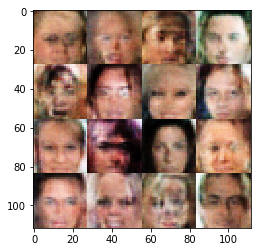

Epoch 0/1... Discriminator Loss: 0.4372... Generator Loss: 1.7834
Epoch 0/1... Discriminator Loss: 0.3736... Generator Loss: 1.9380
Epoch 0/1... Discriminator Loss: 0.7401... Generator Loss: 0.9108
Epoch 0/1... Discriminator Loss: 0.2950... Generator Loss: 1.7641
Epoch 0/1... Discriminator Loss: 0.5330... Generator Loss: 1.5011
Epoch 0/1... Discriminator Loss: 0.3574... Generator Loss: 1.7852
Epoch 0/1... Discriminator Loss: 0.6282... Generator Loss: 2.2035
Epoch 0/1... Discriminator Loss: 0.5824... Generator Loss: 1.2305
Epoch 0/1... Discriminator Loss: 0.5443... Generator Loss: 1.1701
Epoch 0/1... Discriminator Loss: 0.9028... Generator Loss: 0.6845


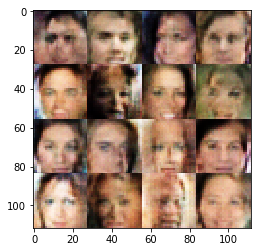

Epoch 0/1... Discriminator Loss: 0.3020... Generator Loss: 2.5105
Epoch 0/1... Discriminator Loss: 0.8407... Generator Loss: 0.8162
Epoch 0/1... Discriminator Loss: 0.4869... Generator Loss: 1.2568
Epoch 0/1... Discriminator Loss: 0.6235... Generator Loss: 1.1241
Epoch 0/1... Discriminator Loss: 0.5131... Generator Loss: 1.4243
Epoch 0/1... Discriminator Loss: 0.4391... Generator Loss: 1.7515
Epoch 0/1... Discriminator Loss: 0.4893... Generator Loss: 1.6600
Epoch 0/1... Discriminator Loss: 0.5664... Generator Loss: 1.2779
Epoch 0/1... Discriminator Loss: 1.3050... Generator Loss: 0.3767
Epoch 0/1... Discriminator Loss: 0.9284... Generator Loss: 0.6756


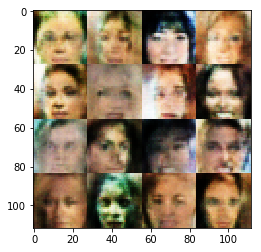

Epoch 0/1... Discriminator Loss: 0.4362... Generator Loss: 1.3792
Epoch 0/1... Discriminator Loss: 0.4106... Generator Loss: 2.2363
Epoch 0/1... Discriminator Loss: 0.5956... Generator Loss: 1.8250
Epoch 0/1... Discriminator Loss: 0.5054... Generator Loss: 1.4107
Epoch 0/1... Discriminator Loss: 0.5002... Generator Loss: 1.3972
Epoch 0/1... Discriminator Loss: 0.9498... Generator Loss: 0.6009
Epoch 0/1... Discriminator Loss: 0.5203... Generator Loss: 1.2926
Epoch 0/1... Discriminator Loss: 0.6437... Generator Loss: 0.9737
Epoch 0/1... Discriminator Loss: 0.5572... Generator Loss: 1.2279
Epoch 0/1... Discriminator Loss: 0.9047... Generator Loss: 0.6367


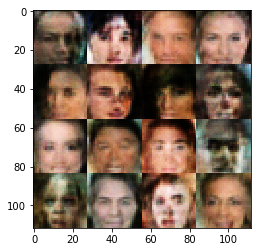

Epoch 0/1... Discriminator Loss: 0.5630... Generator Loss: 1.3093
Epoch 0/1... Discriminator Loss: 0.5258... Generator Loss: 1.2866
Epoch 0/1... Discriminator Loss: 0.5083... Generator Loss: 1.1716
Epoch 0/1... Discriminator Loss: 0.5791... Generator Loss: 1.1966
Epoch 0/1... Discriminator Loss: 0.8716... Generator Loss: 0.7038
Epoch 0/1... Discriminator Loss: 0.9786... Generator Loss: 0.6802
Epoch 0/1... Discriminator Loss: 0.5383... Generator Loss: 1.2480
Epoch 0/1... Discriminator Loss: 0.5363... Generator Loss: 1.2162
Epoch 0/1... Discriminator Loss: 0.6504... Generator Loss: 0.9181
Epoch 0/1... Discriminator Loss: 0.4242... Generator Loss: 1.4042


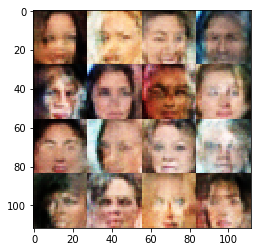

Epoch 0/1... Discriminator Loss: 0.5530... Generator Loss: 1.9938
Epoch 0/1... Discriminator Loss: 0.4912... Generator Loss: 1.1942
Epoch 0/1... Discriminator Loss: 1.0085... Generator Loss: 0.5848
Epoch 0/1... Discriminator Loss: 1.1022... Generator Loss: 0.4943
Epoch 0/1... Discriminator Loss: 0.4328... Generator Loss: 1.5590
Epoch 0/1... Discriminator Loss: 1.3017... Generator Loss: 0.4213
Epoch 0/1... Discriminator Loss: 1.0943... Generator Loss: 0.5573
Epoch 0/1... Discriminator Loss: 0.5921... Generator Loss: 1.0413
Epoch 0/1... Discriminator Loss: 0.6169... Generator Loss: 1.1508
Epoch 0/1... Discriminator Loss: 0.7130... Generator Loss: 0.9725


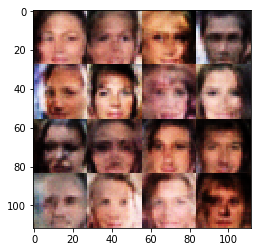

Epoch 0/1... Discriminator Loss: 0.5196... Generator Loss: 1.0573
Epoch 0/1... Discriminator Loss: 0.5584... Generator Loss: 1.1459
Epoch 0/1... Discriminator Loss: 0.5620... Generator Loss: 3.0183
Epoch 0/1... Discriminator Loss: 0.7529... Generator Loss: 0.9093
Epoch 0/1... Discriminator Loss: 0.7659... Generator Loss: 0.7891
Epoch 0/1... Discriminator Loss: 0.6076... Generator Loss: 1.6556
Epoch 0/1... Discriminator Loss: 0.7595... Generator Loss: 0.9213
Epoch 0/1... Discriminator Loss: 0.5110... Generator Loss: 1.5169
Epoch 0/1... Discriminator Loss: 0.4830... Generator Loss: 1.6531
Epoch 0/1... Discriminator Loss: 0.8235... Generator Loss: 0.8709


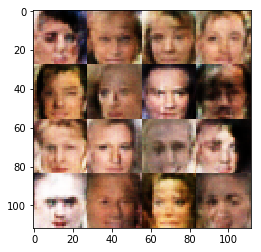

Epoch 0/1... Discriminator Loss: 0.4738... Generator Loss: 1.4095
Epoch 0/1... Discriminator Loss: 0.5330... Generator Loss: 1.3236
Epoch 0/1... Discriminator Loss: 0.2505... Generator Loss: 2.5625
Epoch 0/1... Discriminator Loss: 0.6931... Generator Loss: 1.4771
Epoch 0/1... Discriminator Loss: 0.5534... Generator Loss: 1.2404
Epoch 0/1... Discriminator Loss: 0.4976... Generator Loss: 1.1950
Epoch 0/1... Discriminator Loss: 0.6884... Generator Loss: 1.0277
Epoch 0/1... Discriminator Loss: 0.7018... Generator Loss: 0.8928
Epoch 0/1... Discriminator Loss: 0.5748... Generator Loss: 1.3058
Epoch 0/1... Discriminator Loss: 0.3191... Generator Loss: 2.7965


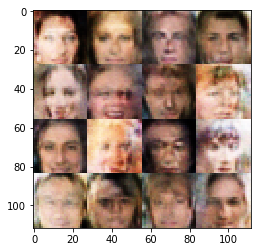

Epoch 0/1... Discriminator Loss: 0.5768... Generator Loss: 1.0577
Epoch 0/1... Discriminator Loss: 0.3186... Generator Loss: 2.0697
Epoch 0/1... Discriminator Loss: 1.3009... Generator Loss: 0.4425
Epoch 0/1... Discriminator Loss: 0.5135... Generator Loss: 1.3086
Epoch 0/1... Discriminator Loss: 0.5579... Generator Loss: 1.0836
Epoch 0/1... Discriminator Loss: 0.4366... Generator Loss: 1.5039
Epoch 0/1... Discriminator Loss: 0.6359... Generator Loss: 1.0430
Epoch 0/1... Discriminator Loss: 0.3563... Generator Loss: 1.7031
Epoch 0/1... Discriminator Loss: 0.4615... Generator Loss: 1.2232
Epoch 0/1... Discriminator Loss: 1.0179... Generator Loss: 0.5478


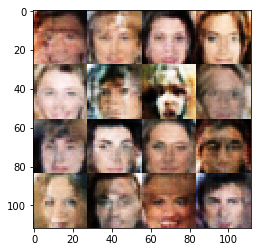

Epoch 0/1... Discriminator Loss: 0.3747... Generator Loss: 2.4146
Epoch 0/1... Discriminator Loss: 0.4826... Generator Loss: 2.0282
Epoch 0/1... Discriminator Loss: 0.3586... Generator Loss: 1.5954
Epoch 0/1... Discriminator Loss: 0.9245... Generator Loss: 0.6436
Epoch 0/1... Discriminator Loss: 0.6183... Generator Loss: 1.0490
Epoch 0/1... Discriminator Loss: 0.5699... Generator Loss: 1.2091
Epoch 0/1... Discriminator Loss: 0.1777... Generator Loss: 2.4337
Epoch 0/1... Discriminator Loss: 0.4534... Generator Loss: 1.3267
Epoch 0/1... Discriminator Loss: 0.7645... Generator Loss: 3.0653
Epoch 0/1... Discriminator Loss: 0.3215... Generator Loss: 2.5616


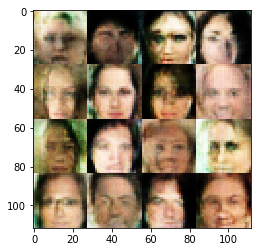

Epoch 0/1... Discriminator Loss: 0.7319... Generator Loss: 0.8271
Epoch 0/1... Discriminator Loss: 0.6545... Generator Loss: 0.9668
Epoch 0/1... Discriminator Loss: 0.4607... Generator Loss: 1.6522
Epoch 0/1... Discriminator Loss: 0.4529... Generator Loss: 2.7008
Epoch 0/1... Discriminator Loss: 0.4297... Generator Loss: 1.6770
Epoch 0/1... Discriminator Loss: 0.5699... Generator Loss: 2.3026
Epoch 0/1... Discriminator Loss: 0.4715... Generator Loss: 1.7876
Epoch 0/1... Discriminator Loss: 0.3595... Generator Loss: 1.6631
Epoch 0/1... Discriminator Loss: 0.3544... Generator Loss: 2.1263
Epoch 0/1... Discriminator Loss: 0.4618... Generator Loss: 1.4373


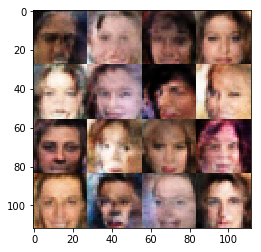

Epoch 0/1... Discriminator Loss: 0.6486... Generator Loss: 1.0294
Epoch 0/1... Discriminator Loss: 0.2949... Generator Loss: 1.8463
Epoch 0/1... Discriminator Loss: 0.5462... Generator Loss: 1.2277
Epoch 0/1... Discriminator Loss: 0.3269... Generator Loss: 1.6065
Epoch 0/1... Discriminator Loss: 0.5078... Generator Loss: 1.4389
Epoch 0/1... Discriminator Loss: 0.5245... Generator Loss: 1.1656
Epoch 0/1... Discriminator Loss: 0.6435... Generator Loss: 0.9594
Epoch 0/1... Discriminator Loss: 0.2481... Generator Loss: 2.0225
Epoch 0/1... Discriminator Loss: 0.5655... Generator Loss: 1.0820
Epoch 0/1... Discriminator Loss: 0.7890... Generator Loss: 1.0493


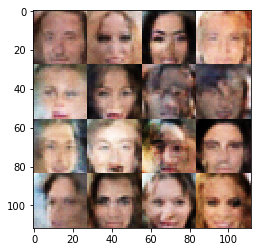

Epoch 0/1... Discriminator Loss: 0.9969... Generator Loss: 0.6430
Epoch 0/1... Discriminator Loss: 1.4015... Generator Loss: 0.3917
Epoch 0/1... Discriminator Loss: 0.6098... Generator Loss: 1.4576
Epoch 0/1... Discriminator Loss: 0.5358... Generator Loss: 1.3797
Epoch 0/1... Discriminator Loss: 0.5714... Generator Loss: 1.1840
Epoch 0/1... Discriminator Loss: 0.3289... Generator Loss: 1.9249
Epoch 0/1... Discriminator Loss: 0.3151... Generator Loss: 1.8358
Epoch 0/1... Discriminator Loss: 0.3385... Generator Loss: 1.9322
Epoch 0/1... Discriminator Loss: 1.1020... Generator Loss: 0.5766
Epoch 0/1... Discriminator Loss: 1.6424... Generator Loss: 0.3914


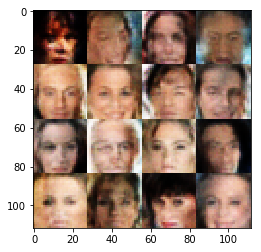

Epoch 0/1... Discriminator Loss: 0.4534... Generator Loss: 1.3908
Epoch 0/1... Discriminator Loss: 0.3450... Generator Loss: 1.6839
Epoch 0/1... Discriminator Loss: 0.4537... Generator Loss: 1.3950
Epoch 0/1... Discriminator Loss: 0.2911... Generator Loss: 1.9998
Epoch 0/1... Discriminator Loss: 0.6545... Generator Loss: 0.9483
Epoch 0/1... Discriminator Loss: 0.5772... Generator Loss: 1.0378
Epoch 0/1... Discriminator Loss: 0.5550... Generator Loss: 1.6100
Epoch 0/1... Discriminator Loss: 0.5351... Generator Loss: 1.1149
Epoch 0/1... Discriminator Loss: 0.4100... Generator Loss: 1.4985
Epoch 0/1... Discriminator Loss: 0.5993... Generator Loss: 1.0181


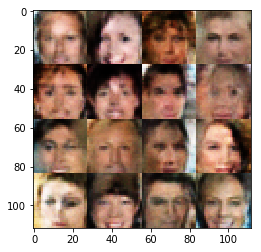

Epoch 0/1... Discriminator Loss: 0.5830... Generator Loss: 1.2391
Epoch 0/1... Discriminator Loss: 0.4044... Generator Loss: 1.4938
Epoch 0/1... Discriminator Loss: 0.4731... Generator Loss: 1.3403
Epoch 0/1... Discriminator Loss: 0.7093... Generator Loss: 0.8741
Epoch 0/1... Discriminator Loss: 0.4895... Generator Loss: 1.3270
Epoch 0/1... Discriminator Loss: 0.3365... Generator Loss: 2.0088
Epoch 0/1... Discriminator Loss: 0.8928... Generator Loss: 0.7023
Epoch 0/1... Discriminator Loss: 0.3914... Generator Loss: 1.5275
Epoch 0/1... Discriminator Loss: 0.6658... Generator Loss: 0.9067
Epoch 0/1... Discriminator Loss: 0.3001... Generator Loss: 1.7645


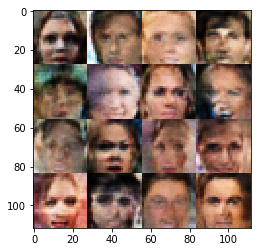

Epoch 0/1... Discriminator Loss: 0.7166... Generator Loss: 0.8766
Epoch 0/1... Discriminator Loss: 0.2584... Generator Loss: 1.9555
Epoch 0/1... Discriminator Loss: 0.5147... Generator Loss: 1.9847
Epoch 0/1... Discriminator Loss: 0.3060... Generator Loss: 1.7529
Epoch 0/1... Discriminator Loss: 0.5800... Generator Loss: 1.0981
Epoch 0/1... Discriminator Loss: 0.6821... Generator Loss: 1.0541
Epoch 0/1... Discriminator Loss: 0.3841... Generator Loss: 3.3877
Epoch 0/1... Discriminator Loss: 0.6382... Generator Loss: 1.0353
Epoch 0/1... Discriminator Loss: 0.5264... Generator Loss: 2.0727
Epoch 0/1... Discriminator Loss: 0.8340... Generator Loss: 0.7915


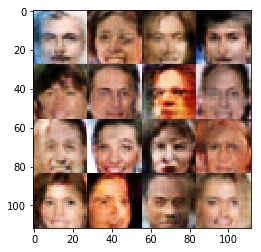

Epoch 0/1... Discriminator Loss: 0.4746... Generator Loss: 1.4682
Epoch 0/1... Discriminator Loss: 0.5414... Generator Loss: 1.0968
Epoch 0/1... Discriminator Loss: 0.5602... Generator Loss: 1.1267
Epoch 0/1... Discriminator Loss: 0.4629... Generator Loss: 1.3211
Epoch 0/1... Discriminator Loss: 0.8398... Generator Loss: 0.7698
Epoch 0/1... Discriminator Loss: 0.6158... Generator Loss: 1.0181
Epoch 0/1... Discriminator Loss: 0.4220... Generator Loss: 1.4318
Epoch 0/1... Discriminator Loss: 0.7201... Generator Loss: 0.9088
Epoch 0/1... Discriminator Loss: 0.3838... Generator Loss: 1.6156
Epoch 0/1... Discriminator Loss: 0.6060... Generator Loss: 2.4216


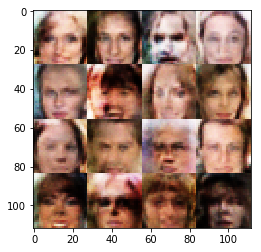

Epoch 0/1... Discriminator Loss: 0.7756... Generator Loss: 0.7838
Epoch 0/1... Discriminator Loss: 0.8812... Generator Loss: 1.0493
Epoch 0/1... Discriminator Loss: 0.5446... Generator Loss: 1.1853
Epoch 0/1... Discriminator Loss: 0.5500... Generator Loss: 1.4369
Epoch 0/1... Discriminator Loss: 0.3296... Generator Loss: 1.5589
Epoch 0/1... Discriminator Loss: 0.4644... Generator Loss: 1.3285
Epoch 0/1... Discriminator Loss: 0.4298... Generator Loss: 1.3439
Epoch 0/1... Discriminator Loss: 0.4565... Generator Loss: 1.2746
Epoch 0/1... Discriminator Loss: 0.5615... Generator Loss: 1.3074
Epoch 0/1... Discriminator Loss: 0.2217... Generator Loss: 3.0165


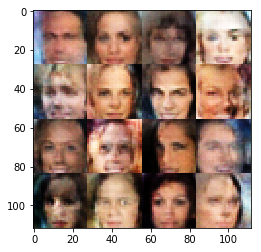

Epoch 0/1... Discriminator Loss: 0.8080... Generator Loss: 0.6862
Epoch 0/1... Discriminator Loss: 0.7806... Generator Loss: 3.4387
Epoch 0/1... Discriminator Loss: 0.4546... Generator Loss: 1.5751
Epoch 0/1... Discriminator Loss: 0.5468... Generator Loss: 1.3080
Epoch 0/1... Discriminator Loss: 0.3904... Generator Loss: 1.4755
Epoch 0/1... Discriminator Loss: 0.5001... Generator Loss: 1.4967
Epoch 0/1... Discriminator Loss: 0.3633... Generator Loss: 1.6533
Epoch 0/1... Discriminator Loss: 0.3752... Generator Loss: 2.0012
Epoch 0/1... Discriminator Loss: 1.1511... Generator Loss: 0.4729
Epoch 0/1... Discriminator Loss: 0.5216... Generator Loss: 1.3091


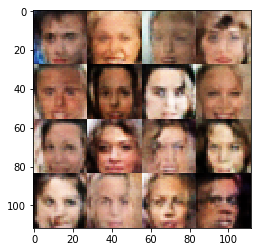

Epoch 0/1... Discriminator Loss: 0.3984... Generator Loss: 1.6101
Epoch 0/1... Discriminator Loss: 0.4105... Generator Loss: 1.4708
Epoch 0/1... Discriminator Loss: 1.3849... Generator Loss: 0.4111
Epoch 0/1... Discriminator Loss: 0.5837... Generator Loss: 1.1384
Epoch 0/1... Discriminator Loss: 0.3959... Generator Loss: 1.4672
Epoch 0/1... Discriminator Loss: 0.4628... Generator Loss: 1.3730
Epoch 0/1... Discriminator Loss: 0.5033... Generator Loss: 1.1903
Epoch 0/1... Discriminator Loss: 0.7014... Generator Loss: 0.9393
Epoch 0/1... Discriminator Loss: 0.3394... Generator Loss: 1.7088
Epoch 0/1... Discriminator Loss: 0.4057... Generator Loss: 1.6590


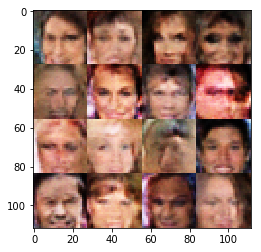

Epoch 0/1... Discriminator Loss: 0.9046... Generator Loss: 0.6219
Epoch 0/1... Discriminator Loss: 0.5439... Generator Loss: 1.5263
Epoch 0/1... Discriminator Loss: 0.3061... Generator Loss: 1.7687
Epoch 0/1... Discriminator Loss: 0.9392... Generator Loss: 3.3228
Epoch 0/1... Discriminator Loss: 0.3270... Generator Loss: 1.8357
Epoch 0/1... Discriminator Loss: 0.2446... Generator Loss: 1.8695
Epoch 0/1... Discriminator Loss: 0.3322... Generator Loss: 2.5465
Epoch 0/1... Discriminator Loss: 0.4651... Generator Loss: 1.3707
Epoch 0/1... Discriminator Loss: 0.4581... Generator Loss: 1.6104
Epoch 0/1... Discriminator Loss: 0.2978... Generator Loss: 2.6671


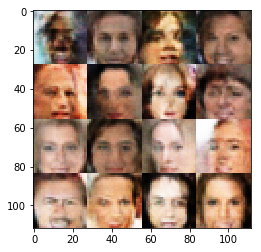

Epoch 0/1... Discriminator Loss: 0.3809... Generator Loss: 1.5333
Epoch 0/1... Discriminator Loss: 0.5761... Generator Loss: 1.1498
Epoch 0/1... Discriminator Loss: 0.7301... Generator Loss: 0.8186
Epoch 0/1... Discriminator Loss: 0.4217... Generator Loss: 1.6302
Epoch 0/1... Discriminator Loss: 0.6038... Generator Loss: 1.0379
Epoch 0/1... Discriminator Loss: 0.5084... Generator Loss: 1.2557
Epoch 0/1... Discriminator Loss: 1.0697... Generator Loss: 0.5498
Epoch 0/1... Discriminator Loss: 0.3787... Generator Loss: 2.1126
Epoch 0/1... Discriminator Loss: 0.3898... Generator Loss: 1.5004
Epoch 0/1... Discriminator Loss: 0.3817... Generator Loss: 1.5032


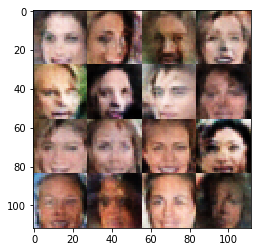

Epoch 0/1... Discriminator Loss: 0.2473... Generator Loss: 2.5265
Epoch 0/1... Discriminator Loss: 0.5352... Generator Loss: 1.3563
Epoch 0/1... Discriminator Loss: 0.6506... Generator Loss: 0.9917
Epoch 0/1... Discriminator Loss: 0.4841... Generator Loss: 1.5026
Epoch 0/1... Discriminator Loss: 0.4977... Generator Loss: 1.2853
Epoch 0/1... Discriminator Loss: 0.6317... Generator Loss: 1.6793
Epoch 0/1... Discriminator Loss: 0.9100... Generator Loss: 0.7171
Epoch 0/1... Discriminator Loss: 0.5598... Generator Loss: 2.1785
Epoch 0/1... Discriminator Loss: 0.4124... Generator Loss: 1.8318
Epoch 0/1... Discriminator Loss: 1.0600... Generator Loss: 0.5421


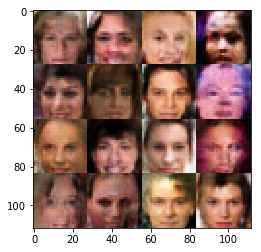

Epoch 0/1... Discriminator Loss: 0.3588... Generator Loss: 1.8504
Epoch 0/1... Discriminator Loss: 0.4480... Generator Loss: 1.6649
Epoch 0/1... Discriminator Loss: 0.6029... Generator Loss: 1.0942
Epoch 0/1... Discriminator Loss: 0.6567... Generator Loss: 1.2365
Epoch 0/1... Discriminator Loss: 0.3282... Generator Loss: 1.5486
Epoch 0/1... Discriminator Loss: 0.4229... Generator Loss: 1.5723
Epoch 0/1... Discriminator Loss: 0.2862... Generator Loss: 2.0617
Epoch 0/1... Discriminator Loss: 0.3265... Generator Loss: 1.7963
Epoch 0/1... Discriminator Loss: 0.4719... Generator Loss: 1.4457
Epoch 0/1... Discriminator Loss: 0.4103... Generator Loss: 1.4966


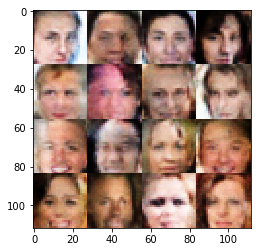

Epoch 0/1... Discriminator Loss: 0.5350... Generator Loss: 1.0832
Epoch 0/1... Discriminator Loss: 0.5221... Generator Loss: 1.2096
Epoch 0/1... Discriminator Loss: 0.3941... Generator Loss: 1.7468
Epoch 0/1... Discriminator Loss: 0.5643... Generator Loss: 1.0801
Epoch 0/1... Discriminator Loss: 0.5660... Generator Loss: 1.1109
Epoch 0/1... Discriminator Loss: 1.0391... Generator Loss: 0.5685
Epoch 0/1... Discriminator Loss: 0.7188... Generator Loss: 0.8217
Epoch 0/1... Discriminator Loss: 0.6420... Generator Loss: 0.9768
Epoch 0/1... Discriminator Loss: 1.3930... Generator Loss: 0.3817
Epoch 0/1... Discriminator Loss: 0.3077... Generator Loss: 2.1666


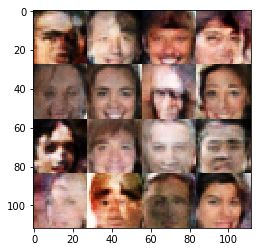

Epoch 0/1... Discriminator Loss: 0.7218... Generator Loss: 0.9139
Epoch 0/1... Discriminator Loss: 0.4351... Generator Loss: 1.3423
Epoch 0/1... Discriminator Loss: 0.3718... Generator Loss: 1.4071
Epoch 0/1... Discriminator Loss: 0.2419... Generator Loss: 2.0960
Epoch 0/1... Discriminator Loss: 0.8064... Generator Loss: 0.7821
Epoch 0/1... Discriminator Loss: 0.3650... Generator Loss: 1.7431
Epoch 0/1... Discriminator Loss: 0.2301... Generator Loss: 2.7848
Epoch 0/1... Discriminator Loss: 0.4553... Generator Loss: 1.3706
Epoch 0/1... Discriminator Loss: 0.7419... Generator Loss: 0.7985
Epoch 0/1... Discriminator Loss: 0.5468... Generator Loss: 1.0825


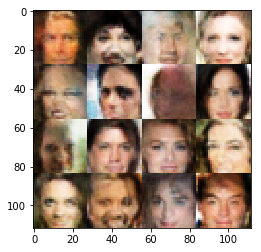

Epoch 0/1... Discriminator Loss: 0.2641... Generator Loss: 2.5152
Epoch 0/1... Discriminator Loss: 0.5195... Generator Loss: 1.7838
Epoch 0/1... Discriminator Loss: 0.5063... Generator Loss: 1.1944
Epoch 0/1... Discriminator Loss: 0.5694... Generator Loss: 1.6880
Epoch 0/1... Discriminator Loss: 0.4089... Generator Loss: 1.2455
Epoch 0/1... Discriminator Loss: 0.7886... Generator Loss: 0.7696
Epoch 0/1... Discriminator Loss: 0.4609... Generator Loss: 1.5837
Epoch 0/1... Discriminator Loss: 0.3773... Generator Loss: 2.6679
Epoch 0/1... Discriminator Loss: 0.2830... Generator Loss: 1.9576
Epoch 0/1... Discriminator Loss: 0.2230... Generator Loss: 2.0004


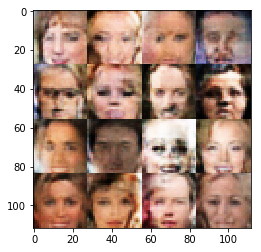

Epoch 0/1... Discriminator Loss: 0.4009... Generator Loss: 1.5717
Epoch 0/1... Discriminator Loss: 0.5413... Generator Loss: 1.3375
Epoch 0/1... Discriminator Loss: 0.4016... Generator Loss: 1.6664
Epoch 0/1... Discriminator Loss: 0.6744... Generator Loss: 0.9227
Epoch 0/1... Discriminator Loss: 0.3262... Generator Loss: 1.9735
Epoch 0/1... Discriminator Loss: 0.4818... Generator Loss: 1.3986
Epoch 0/1... Discriminator Loss: 0.3545... Generator Loss: 1.5049
Epoch 0/1... Discriminator Loss: 0.8859... Generator Loss: 0.8710
Epoch 0/1... Discriminator Loss: 0.6794... Generator Loss: 0.9011
Epoch 0/1... Discriminator Loss: 0.3349... Generator Loss: 1.8221


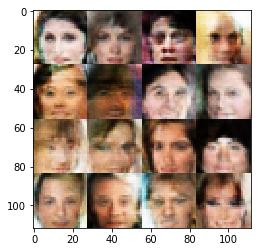

Epoch 0/1... Discriminator Loss: 0.4332... Generator Loss: 1.3444
Epoch 0/1... Discriminator Loss: 0.3591... Generator Loss: 1.5968
Epoch 0/1... Discriminator Loss: 0.4767... Generator Loss: 2.2147
Epoch 0/1... Discriminator Loss: 0.5143... Generator Loss: 1.8241
Epoch 0/1... Discriminator Loss: 0.5708... Generator Loss: 1.1301
Epoch 0/1... Discriminator Loss: 0.1260... Generator Loss: 3.6311
Epoch 0/1... Discriminator Loss: 0.6875... Generator Loss: 1.0557
Epoch 0/1... Discriminator Loss: 0.5969... Generator Loss: 1.0142
Epoch 0/1... Discriminator Loss: 0.4073... Generator Loss: 1.7212
Epoch 0/1... Discriminator Loss: 0.4259... Generator Loss: 1.4409


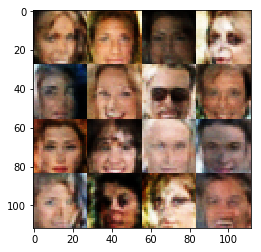

Epoch 0/1... Discriminator Loss: 0.2231... Generator Loss: 2.0796
Epoch 0/1... Discriminator Loss: 0.5005... Generator Loss: 1.5701
Epoch 0/1... Discriminator Loss: 0.3424... Generator Loss: 1.5205
Epoch 0/1... Discriminator Loss: 0.4110... Generator Loss: 2.3216
Epoch 0/1... Discriminator Loss: 0.7472... Generator Loss: 0.8933
Epoch 0/1... Discriminator Loss: 1.1719... Generator Loss: 0.5284
Epoch 0/1... Discriminator Loss: 0.4685... Generator Loss: 1.4138
Epoch 0/1... Discriminator Loss: 0.3699... Generator Loss: 2.0438
Epoch 0/1... Discriminator Loss: 0.5044... Generator Loss: 1.2575
Epoch 0/1... Discriminator Loss: 0.8288... Generator Loss: 0.8151


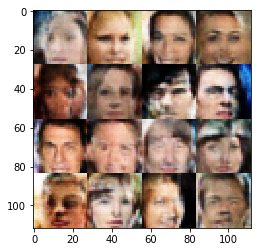

Epoch 0/1... Discriminator Loss: 0.7077... Generator Loss: 0.8639
Epoch 0/1... Discriminator Loss: 0.8789... Generator Loss: 0.6896
Epoch 0/1... Discriminator Loss: 0.2476... Generator Loss: 2.2051
Epoch 0/1... Discriminator Loss: 0.5778... Generator Loss: 1.2500
Epoch 0/1... Discriminator Loss: 0.3613... Generator Loss: 1.7492
Epoch 0/1... Discriminator Loss: 0.4644... Generator Loss: 1.5334
Epoch 0/1... Discriminator Loss: 0.9345... Generator Loss: 0.7672
Epoch 0/1... Discriminator Loss: 0.6430... Generator Loss: 0.9426
Epoch 0/1... Discriminator Loss: 0.2905... Generator Loss: 1.8497
Epoch 0/1... Discriminator Loss: 0.5601... Generator Loss: 1.2385


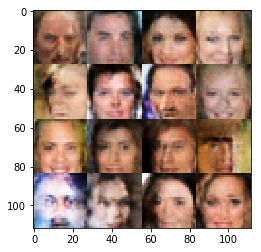

Epoch 0/1... Discriminator Loss: 0.6746... Generator Loss: 0.8543
Epoch 0/1... Discriminator Loss: 0.9261... Generator Loss: 0.6800
Epoch 0/1... Discriminator Loss: 0.9627... Generator Loss: 0.6698
Epoch 0/1... Discriminator Loss: 0.2035... Generator Loss: 3.0602
Epoch 0/1... Discriminator Loss: 0.5101... Generator Loss: 1.1717
Epoch 0/1... Discriminator Loss: 0.2754... Generator Loss: 2.2529
Epoch 0/1... Discriminator Loss: 0.6582... Generator Loss: 2.5236
Epoch 0/1... Discriminator Loss: 0.8040... Generator Loss: 0.7654
Epoch 0/1... Discriminator Loss: 0.6581... Generator Loss: 1.4521
Epoch 0/1... Discriminator Loss: 0.6833... Generator Loss: 2.5021


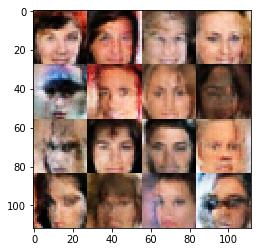

Epoch 0/1... Discriminator Loss: 1.0739... Generator Loss: 0.5500
Epoch 0/1... Discriminator Loss: 0.6263... Generator Loss: 0.9978
Epoch 0/1... Discriminator Loss: 0.7212... Generator Loss: 0.9682
Epoch 0/1... Discriminator Loss: 0.7404... Generator Loss: 0.8704
Epoch 0/1... Discriminator Loss: 0.6300... Generator Loss: 1.0848
Epoch 0/1... Discriminator Loss: 0.1865... Generator Loss: 2.2153
Epoch 0/1... Discriminator Loss: 0.5151... Generator Loss: 1.6946
Epoch 0/1... Discriminator Loss: 0.6355... Generator Loss: 2.8403
Epoch 0/1... Discriminator Loss: 1.0643... Generator Loss: 0.5393
Epoch 0/1... Discriminator Loss: 0.5729... Generator Loss: 1.1915


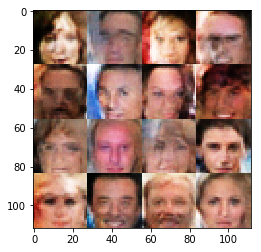

Epoch 0/1... Discriminator Loss: 0.4261... Generator Loss: 1.4846
Epoch 0/1... Discriminator Loss: 0.2341... Generator Loss: 2.5605
Epoch 0/1... Discriminator Loss: 0.6600... Generator Loss: 0.9444
Epoch 0/1... Discriminator Loss: 0.5184... Generator Loss: 2.2387
Epoch 0/1... Discriminator Loss: 0.5677... Generator Loss: 1.1045
Epoch 0/1... Discriminator Loss: 0.5369... Generator Loss: 1.2560
Epoch 0/1... Discriminator Loss: 0.2787... Generator Loss: 1.7665
Epoch 0/1... Discriminator Loss: 1.3219... Generator Loss: 0.4343
Epoch 0/1... Discriminator Loss: 0.8791... Generator Loss: 0.7628
Epoch 0/1... Discriminator Loss: 0.3373... Generator Loss: 1.7968


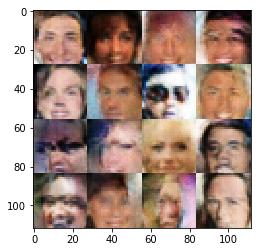

Epoch 0/1... Discriminator Loss: 0.4226... Generator Loss: 1.4783
Epoch 0/1... Discriminator Loss: 0.2672... Generator Loss: 2.7409
Epoch 0/1... Discriminator Loss: 0.4677... Generator Loss: 1.4310
Epoch 0/1... Discriminator Loss: 0.8965... Generator Loss: 0.7817
Epoch 0/1... Discriminator Loss: 0.2758... Generator Loss: 2.1816
Epoch 0/1... Discriminator Loss: 0.7007... Generator Loss: 0.9184
Epoch 0/1... Discriminator Loss: 0.3713... Generator Loss: 1.5531
Epoch 0/1... Discriminator Loss: 0.3249... Generator Loss: 1.7398
Epoch 0/1... Discriminator Loss: 0.2848... Generator Loss: 2.0235
Epoch 0/1... Discriminator Loss: 0.5595... Generator Loss: 1.1453


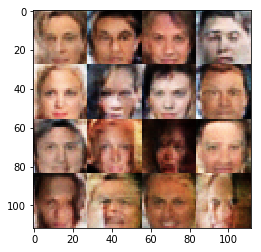

Epoch 0/1... Discriminator Loss: 0.5876... Generator Loss: 1.1002
Epoch 0/1... Discriminator Loss: 0.3428... Generator Loss: 1.5664
Epoch 0/1... Discriminator Loss: 0.3104... Generator Loss: 2.0453
Epoch 0/1... Discriminator Loss: 0.8058... Generator Loss: 0.8522
Epoch 0/1... Discriminator Loss: 1.2910... Generator Loss: 0.4676
Epoch 0/1... Discriminator Loss: 1.4192... Generator Loss: 0.3874
Epoch 0/1... Discriminator Loss: 0.6268... Generator Loss: 1.0105
Epoch 0/1... Discriminator Loss: 1.1803... Generator Loss: 0.4972
Epoch 0/1... Discriminator Loss: 0.7363... Generator Loss: 0.9058
Epoch 0/1... Discriminator Loss: 0.5608... Generator Loss: 1.1410


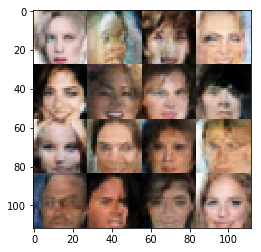

Epoch 0/1... Discriminator Loss: 0.9127... Generator Loss: 0.6512
Epoch 0/1... Discriminator Loss: 0.5428... Generator Loss: 1.2397
Epoch 0/1... Discriminator Loss: 1.1166... Generator Loss: 0.5180
Epoch 0/1... Discriminator Loss: 0.4215... Generator Loss: 1.6608
Epoch 0/1... Discriminator Loss: 0.5314... Generator Loss: 1.2284
Epoch 0/1... Discriminator Loss: 0.5556... Generator Loss: 1.0722
Epoch 0/1... Discriminator Loss: 0.2211... Generator Loss: 2.0752
Epoch 0/1... Discriminator Loss: 0.4991... Generator Loss: 1.5238
Epoch 0/1... Discriminator Loss: 1.0787... Generator Loss: 0.5648
Epoch 0/1... Discriminator Loss: 0.3909... Generator Loss: 1.5984


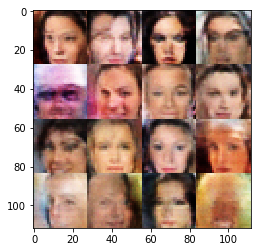

Epoch 0/1... Discriminator Loss: 0.9082... Generator Loss: 0.6441
Epoch 0/1... Discriminator Loss: 0.6358... Generator Loss: 1.4606
Epoch 0/1... Discriminator Loss: 0.4122... Generator Loss: 2.2692
Epoch 0/1... Discriminator Loss: 0.3728... Generator Loss: 1.9419
Epoch 0/1... Discriminator Loss: 0.5293... Generator Loss: 1.2085
Epoch 0/1... Discriminator Loss: 0.2535... Generator Loss: 1.8579
Epoch 0/1... Discriminator Loss: 0.3843... Generator Loss: 1.6445
Epoch 0/1... Discriminator Loss: 0.5416... Generator Loss: 1.1702
Epoch 0/1... Discriminator Loss: 0.4482... Generator Loss: 1.4361
Epoch 0/1... Discriminator Loss: 0.6896... Generator Loss: 0.9179


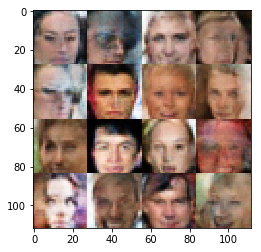

Epoch 0/1... Discriminator Loss: 0.5708... Generator Loss: 1.4091
Epoch 0/1... Discriminator Loss: 0.2173... Generator Loss: 1.9447
Epoch 0/1... Discriminator Loss: 0.7036... Generator Loss: 0.9133
Epoch 0/1... Discriminator Loss: 0.5946... Generator Loss: 1.8340
Epoch 0/1... Discriminator Loss: 1.1454... Generator Loss: 0.4936
Epoch 0/1... Discriminator Loss: 0.3109... Generator Loss: 1.7070
Epoch 0/1... Discriminator Loss: 0.5135... Generator Loss: 1.2526
Epoch 0/1... Discriminator Loss: 0.4781... Generator Loss: 1.4276
Epoch 0/1... Discriminator Loss: 0.7143... Generator Loss: 0.9555
Epoch 0/1... Discriminator Loss: 1.1014... Generator Loss: 0.4667


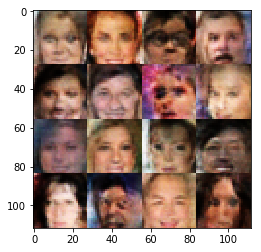

Epoch 0/1... Discriminator Loss: 0.4204... Generator Loss: 1.2622
Epoch 0/1... Discriminator Loss: 0.8210... Generator Loss: 0.7214
Epoch 0/1... Discriminator Loss: 0.5175... Generator Loss: 1.8573
Epoch 0/1... Discriminator Loss: 0.2986... Generator Loss: 1.9028
Epoch 0/1... Discriminator Loss: 0.3882... Generator Loss: 1.7467
Epoch 0/1... Discriminator Loss: 0.6667... Generator Loss: 0.9484
Epoch 0/1... Discriminator Loss: 0.4000... Generator Loss: 1.8953
Epoch 0/1... Discriminator Loss: 0.6085... Generator Loss: 0.9675
Epoch 0/1... Discriminator Loss: 0.5250... Generator Loss: 1.2873
Epoch 0/1... Discriminator Loss: 0.3130... Generator Loss: 2.4455


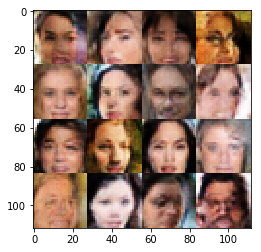

Epoch 0/1... Discriminator Loss: 0.4244... Generator Loss: 2.2545
Epoch 0/1... Discriminator Loss: 0.2648... Generator Loss: 2.0031
Epoch 0/1... Discriminator Loss: 0.2369... Generator Loss: 3.4370
Epoch 0/1... Discriminator Loss: 0.3967... Generator Loss: 1.6370
Epoch 0/1... Discriminator Loss: 0.8264... Generator Loss: 0.7359
Epoch 0/1... Discriminator Loss: 0.6890... Generator Loss: 0.9932
Epoch 0/1... Discriminator Loss: 0.4493... Generator Loss: 1.6346
Epoch 0/1... Discriminator Loss: 0.7989... Generator Loss: 0.7906
Epoch 0/1... Discriminator Loss: 0.7895... Generator Loss: 0.7709
Epoch 0/1... Discriminator Loss: 0.6092... Generator Loss: 1.0718


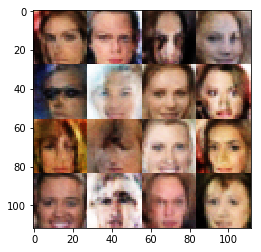

Epoch 0/1... Discriminator Loss: 0.6327... Generator Loss: 1.0281
Epoch 0/1... Discriminator Loss: 0.4734... Generator Loss: 1.6908
Epoch 0/1... Discriminator Loss: 1.0900... Generator Loss: 0.5190
Epoch 0/1... Discriminator Loss: 0.6938... Generator Loss: 0.8247
Epoch 0/1... Discriminator Loss: 0.6567... Generator Loss: 0.9587
Epoch 0/1... Discriminator Loss: 1.6528... Generator Loss: 0.3050
Epoch 0/1... Discriminator Loss: 0.5993... Generator Loss: 1.0901
Epoch 0/1... Discriminator Loss: 0.4614... Generator Loss: 1.4640
Epoch 0/1... Discriminator Loss: 0.7316... Generator Loss: 0.8335
Epoch 0/1... Discriminator Loss: 0.3072... Generator Loss: 1.7758


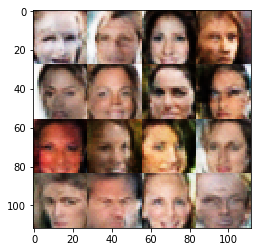

Epoch 0/1... Discriminator Loss: 0.9449... Generator Loss: 0.6613
Epoch 0/1... Discriminator Loss: 0.4101... Generator Loss: 1.5165
Epoch 0/1... Discriminator Loss: 0.4790... Generator Loss: 2.6674
Epoch 0/1... Discriminator Loss: 0.8925... Generator Loss: 0.6813
Epoch 0/1... Discriminator Loss: 0.4787... Generator Loss: 1.3424
Epoch 0/1... Discriminator Loss: 0.2726... Generator Loss: 1.8766
Epoch 0/1... Discriminator Loss: 1.0302... Generator Loss: 0.5810
Epoch 0/1... Discriminator Loss: 0.2826... Generator Loss: 1.7559
Epoch 0/1... Discriminator Loss: 0.4344... Generator Loss: 1.5365
Epoch 0/1... Discriminator Loss: 0.6658... Generator Loss: 0.9030


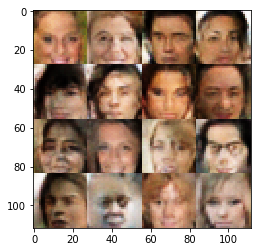

Epoch 0/1... Discriminator Loss: 0.4984... Generator Loss: 1.3202
Epoch 0/1... Discriminator Loss: 0.7797... Generator Loss: 0.7546
Epoch 0/1... Discriminator Loss: 0.2909... Generator Loss: 2.1241
Epoch 0/1... Discriminator Loss: 0.2497... Generator Loss: 1.7877
Epoch 0/1... Discriminator Loss: 0.6925... Generator Loss: 0.9121
Epoch 0/1... Discriminator Loss: 0.5763... Generator Loss: 1.1139
Epoch 0/1... Discriminator Loss: 0.4081... Generator Loss: 1.5448
Epoch 0/1... Discriminator Loss: 0.2559... Generator Loss: 2.1595
Epoch 0/1... Discriminator Loss: 1.5279... Generator Loss: 0.3188
Epoch 0/1... Discriminator Loss: 0.6920... Generator Loss: 0.9001


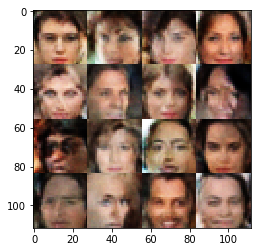

Epoch 0/1... Discriminator Loss: 0.2524... Generator Loss: 2.2516
Epoch 0/1... Discriminator Loss: 0.7157... Generator Loss: 0.9032
Epoch 0/1... Discriminator Loss: 0.2357... Generator Loss: 2.0551


In [26]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.